In [173]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()

### set this to determine what data to process

####### NOTE !!!!! ##########
#############################
### since 2020-04-23 US states no longer work since CSSE changed their format ####
### FIXED sometime early may !#### 

#############################
#############################

US_states = False

### 
### MUST RUN create_world_df_for_regression FIRST!!!!! 
World_countries = True
### 

In [174]:
#### US STATES SPECIFIC FRAME ####

if US_states:
    
    title = 'US States'
    dick = pd.read_pickle('us_state_dict.pkl')


    states_timeline = pd.DataFrame()
    for state,timeline in dick.items():
        temp = pd.DataFrame(data=timeline,index=timeline.index).reset_index()
        temp['state'] = state
        states_timeline = pd.concat([states_timeline,temp])

    states_timeline['density2'] = states_timeline['density'].copy() * -1 * np.random.lognormal(0.1,0.01) # to do test regression on itself
    states_timeline['conf_log'] = np.log10(states_timeline['confirmed'])
    states_timeline['dead_log'] = np.log10(states_timeline['deceased'])
    states_timeline['density_log'] = np.log10(states_timeline['density'])

    states_timeline.replace(np.inf,np.nan,inplace=True)
    states_timeline.dropna(inplace=True)

    states_timeline

In [175]:
if US_states:
    us_abb = pd.read_csv('us_states.csv',sep=';',header=None,index_col=0,usecols=[0,3],names=['state','abb'])


if World_countries:
    
    world_pop = pd.read_csv('world_pop.csv',sep=';',header=None,thousands=',',index_col=0,names=['pop'])
    
    world_lat_lon = pd.read_csv('world_lat_lon.csv',sep='\t',index_col=3)
    
    world_facts = pd.read_pickle('world_facts.pkl')
    us_abb = pd.DataFrame(world_facts['abb'])
    world_facts['density_log'] = np.log10(world_facts['density'])
    world_facts = world_facts.join(world_lat_lon['lat'])
    world_facts['lat'] = np.abs(world_facts['lat'])
    world_facts['lat_log'] = np.log10(world_facts['lat'])
    world_facts = world_facts.join(world_pop)
    world_facts['dead_per_M'] = world_facts['deceased'] /(world_facts['pop'] / 1e6)
    world_facts['dead_per_M_log'] = np.log10(world_facts['dead_per_M'])
    print (world_facts.loc['Sweden'])
    print (world_facts.describe())


confirmed               84294
factor                1.00527
inc                       442
deceased                 5783
dead_factor           1.00121
dead_inc                    7
pct_dead              6.86051
conf_log               4.9258
dead_log              3.76215
density               22.4281
pop2020           1.00993e+07
area                   450295
gdp                     54075
median_age               41.2
abb                        SE
density_log           1.35079
gdp_log                 4.733
GDP_tot           5.46118e+11
gini                     24.9
gdp_cat                     4
lat                   60.1282
lat_log               1.77908
pop               1.00993e+07
dead_per_M            572.616
dead_per_M_log        2.75786
Name: Sweden, dtype: object
          confirmed      factor           inc       deceased  dead_factor  \
count  1.510000e+02  151.000000    151.000000     151.000000   151.000000   
mean   1.390509e+05    1.014331   1654.894040    5045.377483     1.0

In [176]:
#world_facts.loc[world_facts['abb'] == 'KE']

In [177]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    df = pd.DataFrame()

    def get_latest_numbers(df,statename):
        state = dick[statename]
        last_row = pd.DataFrame(state.iloc[-1]).T
        last_row['state'] = statename
        df = pd.concat([df,last_row],axis=0)
        return df

    for key,data in dick.items():
        df = get_latest_numbers(df,key)
    
    #df.sort_values('dead_per_M',inplace=True,ascending=False)
    df.head(40)
    #df.to_pickle('US_states_latest_day.pkl')


In [178]:


us_age = pd.read_csv('us_states_age.csv',sep=r'\t',header=None,engine='python',usecols=[1,2],
                     names=['state','median_age'],index_col=0)

us_age.index = us_age.index.str.strip()
us_age

median_age
state                           
Maine                       44.9
New Hampshire               43.0
Vermont                     42.8
West Virginia               42.7
Florida                     42.2
Puerto Rico                 41.5
Connecticut                 41.0
Pennsylvania                40.8
Delaware                    40.7
Rhode Island                40.1
New Jersey                  40.0
Montana                     39.9
Michigan                    39.8
South Carolina              39.6
Wisconsin                   39.6
Massachusetts               39.4
Ohio                        39.4
Oregon                      39.4
Alabama                     39.2
Hawaii                      39.2
New York                    39.0
Kentucky                    38.9
North Carolina              38.9
Maryland                    38.8
Tennessee                   38.8
Missouri                    38.7
Virginia                    38.4
Arkansas                    38.3
Illinois                    38.3
Iowa                        38.2
Minnesota                   38.1
Nevada                      38.1
New Mexico                  38.1
Wyoming                     38.0
Arizona                     37.9
Indiana                     37.9
Mississippi                 37.7
Washington                  37.7
Louisiana                   37.2
South Dakota                37.1
Colorado                    36.9
Georgia                     36.9
Kansas                      36.9
California                  36.8
Oklahoma                    36.7
Idaho                       36.6
Nebraska                    36.6
North Dakota                35.2
Texas                       34.8
Alaska                      34.6
District of Columbia        34.0
Utah                        31.0

In [179]:
if US_states:
    #us_df = pd.read_pickle('US_states_latest_day.pkl')
    us_df = df
    us_df['gdp_per_capita'] = us_df['gdp']
    us_df['density2'] = us_df['density'].copy() * -1 * np.random.lognormal(0.1,0.01) ## to test regress on itself
    us_df['conf_log'] = np.log10(us_df['confirmed'])
    us_df['dead_log'] = np.log10(us_df['deceased'])
    us_df['density_log'] = np.log10(us_df['density'])
    us_df['gdp_log'] = np.log10(us_df['gdp'])
    us_df['dead_per_M_log'] = np.log10(us_df['dead_per_M'])
    
    us_df.set_index('state',inplace=True)
    us_df = us_df.join(us_age)
    
    lat_lon = pd.read_csv('us_lat_lon.csv',sep=';',index_col=0)
    us_df = us_df.join(lat_lon)
    us_df['lat_log'] = np.log10(us_df['lat'])
    print(us_df)
    



In [180]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    print (us_df.describe())

In [181]:

def regression(x1,x2,y):
    
    model = pm.Model()
    with model:
    
        beta1_mu = pm.Uniform('beta1_mu',-0.1,0.1)
        beta1_sigma = pm.Uniform('beta1_sigma',0,0.5)

        beta2_mu = pm.Uniform('beta2_mu',-0.1,0.1)
        beta2_sigma = pm.Uniform('beta2_sigma',0,0.5)

        obs_sigma = pm.Uniform('obs_sigma',0,0.5)

        alpha = pm.Uniform('alpha',-1,1)

        beta1 = pm.Normal('beta1',mu=beta1_mu, sd=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu, sd=beta2_sigma )


        if multiple_regression:
            
            linreq = x1.values * beta1 + x2.values*beta2 + alpha

        else:
            
            linreq = x1.values * beta1 + alpha

        obs = pm.Normal('obs',mu=linreq,sd=obs_sigma,observed=y)

        step1 = pm.Metropolis()
        
        trace = pm.sample(10000,step=step1,tune=10000)

        beta1_mu_post = trace['beta1_mu'][:]
        beta1_sigma_post = trace['beta1_sigma'][:]

        if multiple_regression:
            beta2_mu_post = trace['beta2_mu'][:]
            beta2_sigma_post = trace['beta2_sigma'][:]

        obs_sigma_post = trace['obs_sigma'][:]

        alpha_post = trace['alpha'][:]

        beta1_post = trace['beta1'][:]


        if multiple_regression:

            beta2_post = trace['beta2'][:]

            

            result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                                  'beta1_sigma_post' : beta1_sigma_post,
                                  'beta2_mu_post' : beta2_mu_post,
                                  'beta2_sigma_post' : beta2_sigma_post,
                                  'obs_sigma_post' : obs_sigma_post,
                                  'alpha_post' : alpha_post,
                                  'beta1_post' : beta1_post,
                                  'beta2_post' : beta2_post})

        else:
            result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                                  'beta1_sigma_post' : beta1_sigma_post,
                                  'obs_sigma_post' : obs_sigma_post,
                                  'alpha_post' : alpha_post,
                                  'beta1_post' : beta1_post})
        _= az.plot_trace(trace)
            
        print (az.summary(trace,round_to=2))
            
        
        return result







In [182]:
world_facts

confirmed    factor      inc  deceased  dead_factor  \
US                   5313055.0  1.012231  64201.0  168446.0     1.007995   
China                  89214.0  1.000785     70.0    4701.0     1.000213   
Japan                  53818.0  1.025671   1347.0    1080.0     1.006524   
Germany               223791.0  1.006793   1510.0    9230.0     1.001410   
India                2525922.0  1.026301  64732.0   49036.0     1.020733   
...                        ...       ...      ...       ...          ...   
San Marino               699.0  1.000000      0.0      42.0     1.000000   
Gambia                  1623.0  1.043059     67.0      50.0     1.162791   
Antigua and Barbuda       93.0  1.010870      1.0       3.0     1.000000   
Guinea-Bissau           2088.0  1.000000      0.0      29.0     1.000000   
Comoros                  403.0  1.010025      4.0       7.0     1.000000   

                     dead_inc  pct_dead  conf_log  dead_log   density  ...  \
US                     1336.0  3.170417  6.725344  5.226461   35.3160  ...   
China                     1.0  5.269352  4.950433  3.672190  148.2775  ...   
Japan                     7.0  2.006764  4.730928  3.033424  334.6558  ...   
Germany                  13.0  4.124384  5.349843  3.965202  234.6140  ...   
India                   996.0  1.941311  6.402420  4.690515  419.7617  ...   
...                       ...       ...       ...       ...       ...  ...   
San Marino                0.0  6.008584  2.844477  1.623249  556.2459  ...   
Gambia                    7.0  3.080715  3.210319  1.698970  226.0893  ...   
Antigua and Barbuda       0.0  3.225806  1.968483  0.477121  221.5588  ...   
Guinea-Bissau             0.0  1.388889  3.319730  1.462398   54.4775  ...   
Comoros                   0.0  1.736973  2.605305  0.845098  467.0252  ...   

                     density_log   gdp_log       GDP_tot  gini gdp_cat  \
US                      1.547972  4.777709  1.983997e+13  45.0       4   
China                   2.171075  3.935104  1.239546e+13  46.5       3   
Japan                   2.524598  4.582222  4.833171e+12  37.9       4   
Germany                 2.370354  4.650113  3.743467e+12  27.0       4   
India                   2.623003  3.296665  2.732409e+12  35.2       2   
...                          ...       ...           ...   ...     ...   
San Marino              2.745267  4.685697  1.645484e+09   NaN       4   
Gambia                  2.354280  2.828015  1.626418e+09   NaN       1   
Antigua and Barbuda     2.345489  4.199344  1.549726e+09   NaN       3   
Guinea-Bissau           1.736217  2.867467  1.450417e+09   NaN       1   
Comoros                 2.669340  3.117934  1.140917e+09  55.9       1   

                           lat   lat_log           pop   dead_per_M  \
US                   37.090240  1.569260  3.310027e+08   508.896226   
China                35.861660  1.554630  1.439324e+09     3.266117   
Japan                36.204824  1.558766  1.264765e+08     8.539138   
Germany              51.165691  1.708979  8.378394e+07   110.164308   
India                20.593684  1.313734  1.380004e+09    35.533220   
...                        ...       ...           ...          ...   
San Marino           43.942360  1.642883  3.393100e+04  1237.806136   
Gambia               13.443182  1.128502  2.416668e+06    20.689644   
Antigua and Barbuda  17.060816  1.232000  9.792900e+04    30.634439   
Guinea-Bissau        11.803749  1.072020  1.968001e+06    14.735765   
Comoros              11.875001  1.074634  8.696010e+05     8.049669   

                    dead_per_M_log  
US                        2.706629  
China                     0.514032  
Japan                     0.931414  
Germany                   2.042041  
India                     1.550635  
...                            ...  
San Marino                3.092653  
Gambia                    1.315753  
Antigua and Barbuda       1.486210  
Guinea-Bissau             1.168373  
Comoros               

In [183]:
abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=0,usecols=[0,2],names=['country','abb3'])
world_facts = world_facts.join(abb)

In [184]:
start_date = '2020-03-01'
end_date = '2020-08-13'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

import requests
r = requests.get(url,timeout=5.0)
r.status_code

200

In [185]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07',
               '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11',
               '2020-08-12', '2020-08-13'],
              dtype='datetime64[ns]', length=166, freq='D')

In [186]:
json = r.json()
data = json['data']
countries = json['countries']

In [187]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass


In [188]:
ox_df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
ox_df['date'] = pd.to_datetime(ox_df['date'])
ox_df = ox_df.set_index(['country','date'])
print (ox_df.head())

                    confirmed  dead  oxford_stringency
country date                                          
ABW     2020-03-01        NaN   NaN               0.00
AFG     2020-03-01        1.0   0.0              27.78
AGO     2020-03-01        NaN   NaN               8.33
AIA     2020-03-01        NaN   NaN               8.33
ALB     2020-03-01        NaN   NaN               8.33


In [189]:
ox_df = ox_df.groupby(level=0).mean()['oxford_stringency']
ox_df

country
ABW    47.951761
AFG    72.957244
AGO    68.882956
AIA    50.593821
ALB    71.375912
         ...    
VUT    59.987848
YEM    42.719182
ZAF    73.847296
ZMB    44.964241
ZWE    70.951447
Name: oxford_stringency, Length: 183, dtype: float64

In [190]:
world_facts = world_facts.join(ox_df,on='abb3')


In [191]:
world_facts = world_facts.loc[~world_facts['oxford_stringency'].isna()]
world_facts

confirmed    factor      inc  deceased  dead_factor  \
US                        5313055.0  1.012231  64201.0  168446.0     1.007995   
China                       89214.0  1.000785     70.0    4701.0     1.000213   
Japan                       53818.0  1.025671   1347.0    1080.0     1.006524   
Germany                    223791.0  1.006793   1510.0    9230.0     1.001410   
India                     2525922.0  1.026301  64732.0   49036.0     1.020733   
...                             ...       ...      ...       ...          ...   
Lesotho                       884.0  1.000000      0.0      25.0     1.000000   
Central African Republic     4652.0  1.000000      0.0      61.0     1.000000   
Belize                        356.0  1.202703     60.0       3.0     1.500000   
San Marino                    699.0  1.000000      0.0      42.0     1.000000   
Gambia                       1623.0  1.043059     67.0      50.0     1.162791   

                          dead_inc  pct_dead  conf_log  dead_log   density  \
US                          1336.0  3.170417  6.725344  5.226461   35.3160   
China                          1.0  5.269352  4.950433  3.672190  148.2775   
Japan                          7.0  2.006764  4.730928  3.033424  334.6558   
Germany                       13.0  4.124384  5.349843  3.965202  234.6140   
India                        996.0  1.941311  6.402420  4.690515  419.7617   
...                            ...       ...       ...       ...       ...   
Lesotho                        0.0  2.828054  2.946452  1.397940   70.5732   
Central African Republic       0.0  1.311264  3.667640  1.785330    7.7526   
Belize                         1.0  0.842697  2.551450  0.477121   17.3138   
San Marino                     0.0  6.008584  2.844477  1.623249  556.2459   
Gambia                         7.0  3.080715  3.210319  1.698970  226.0893   

                          ...       GDP_tot  gini  gdp_cat        lat  \
US                        ...  1.983997e+13  45.0        4  37.090240   
China                     ...  1.239546e+13  46.5        3  35.861660   
Japan                     ...  4.833171e+12  37.9        4  36.204824   
Germany                   ...  3.743467e+12  27.0        4  51.165691   
India                     ...  2.732409e+12  35.2        2  20.593684   
...                       ...           ...   ...      ...        ...   
Lesotho                   ...  2.641393e+09  63.2        1  29.609988   
Central African Republic  ...  2.047821e+09   NaN        1   6.611111   
Belize                    ...  1.971042e+09   NaN        2  17.189877   
San Marino                ...  1.645484e+09   NaN        4  43.942360   
Gambia                    ...  1.626418e+09   NaN        1  13.443182   

                           lat_log           pop   dead_per_M  dead_per_M_log  \
US                        1.569260  3.310027e+08   508.896226        2.706629   
China                     1.554630  1.439324e+09     3.266117        0.514032   
Japan                     1.558766  1.264765e+08     8.539138        0.931414   
Germany                   1.708979  8.378394e+07   110.164308        2.042041   
India                     1.313734  1.380004e+09    35.533220        1.550635   
...                            ...           ...          ...             ...   
Lesotho                   1.471438  2.142249e+06    11.669979        1.067070   
Central African Republic  0.820274  4.829767e+06    12.630009        1.101404   
Belize                    1.235273  3.976280e+05     7.544740        0.877644   
San Marino                1.642883  3.393100e+04  1237.806136        3.092653   
Gambia                    1.128502  2.416668e+06    20.689644        1.315753   

                          abb3 oxford_stringency  
US                         USA         66.205660  
China                      CHN         75.652390  
Japan                      JPN         36.022390  
Germany                    DEU         61.284717  
India      

In [192]:
#################################### HERE STARTS THE GENERIC BIT #####################################

# independent1, independent2, dependent

x1_param = x1_param_org = 'oxford_stringency'
x2_param = x2_param_org = 'lat'
y_param = y_param_org = 'dead_per_M_log'

#x1_param = 'x_real'
#x2_param = 'x_spurious'
#y_param = 'y'

multiple_regression = True

outlier = 10

### REPLACE THE ASSIGNMENT TO xy BELOW WITH THE DATAFRAME YOU WANT TO RUN REGRESSION ON ###
### AND CHANGE x1_param,x2_param,y_param above to correct column names and set US_states in top frame to True/False ###

if US_states:
    xy = us_df[[x1_param,x2_param,y_param]].copy()
    title = 'US states'

if World_countries:
    xy = world_facts[[x1_param,x2_param,y_param]]
    title = 'World countries'

# THIS IS A DATASET FOR UNDERSTANDING 
if not (US_states or World_countries):
    xy = pd.read_pickle('spurious_correlation.pkl')
    
    

In [193]:
if xy.isna().any().sum():
    print ('Warning - NaN values present! DROPPING....')
    xy.dropna(inplace=True)

Warning - NaN values present! DROPPING....


<ipython-input-193-a00600b88f91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy.dropna(inplace=True)


In [194]:
def standardize(x):
    return (x - x.mean()) / x.std()



######################################################################################################

xy[['x1_std','x2_std','y_std']] = xy.apply(standardize)

mask = (xy[['x1_std','x2_std','y_std']] > outlier).any(axis=1)

xy = (xy[~mask]).copy()

true_x1_mean = np.power(10,xy[x1_param]).mean() if ('_log' in x1_param) else xy[x1_param].mean()
true_x1_std = np.power(10,xy[x1_param]).std() if ('_log' in x1_param) else xy[x1_param].std()
true_x2_mean = np.power(10,xy[x2_param]).mean() if ('_log' in x2_param) else xy[x2_param].mean()
true_x2_std = np.power(10,xy[x2_param]).std() if ('_log' in x2_param) else xy[x2_param].std()
true_y_mean = np.power(10,xy[y_param]).mean() if ('_log' in y_param) else xy[y_param].mean()
true_y_std = np.power(10,xy[y_param]).std() if ('_log' in y_param) else xy[y_param].std()

print (xy)
print (xy.describe())

xy_orig = xy.copy()


                          oxford_stringency        lat  dead_per_M_log  \
US                                66.205660  37.090240        2.706629   
China                             75.652390  35.861660        0.514032   
Japan                             36.022390  36.204824        0.931414   
Germany                           61.284717  51.165691        2.042041   
India                             77.632264  20.593684        1.550635   
...                                     ...        ...             ...   
Lesotho                           63.806516  29.609988        1.067070   
Central African Republic          57.244340   6.611111        1.101404   
Belize                            63.976792  17.189877        0.877644   
San Marino                        59.537862  43.942360        3.092653   
Gambia                            63.106352  13.443182        1.315753   

                            x1_std    x2_std     y_std  
US                        0.194587  0.549390  1.509353

/usr/local/lib64/python3.8/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.33  0.04    0.25     0.40        0.0      0.0   3094.78   
beta2        0.52  0.04    0.44     0.60        0.0      0.0   3797.24   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   3563.70   
beta1_sigma  0.32  0.10    0.16     0.50        0.0      0.0   3526.78   
beta2_mu     0.01  0.06   -0.08     0.10        0.0      0.0   3946.82   
beta2_sigma  0.37  0.08    0.23     0.50        0.0      0.0   3635.26   
obs_sigma    0.50  0.00    0.49     0.50        0.0      0.0   4381.81   
alpha       -0.00  0.04   -0.08     0.08        0.0      0.0   3696.02   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3085.85   3108.27   4009.68    1.0  
beta2        3797.24   3805.18   4638.12    1.0  
beta1_mu     3346.85   3436.70   3932.39    1.0  
beta1_sigma  3407.64   3370.83   3939.68    1.0  
beta2_mu     3538.25   3849.71   3748.37    1.0  
beta2_sigma  3567.51   3428.62   

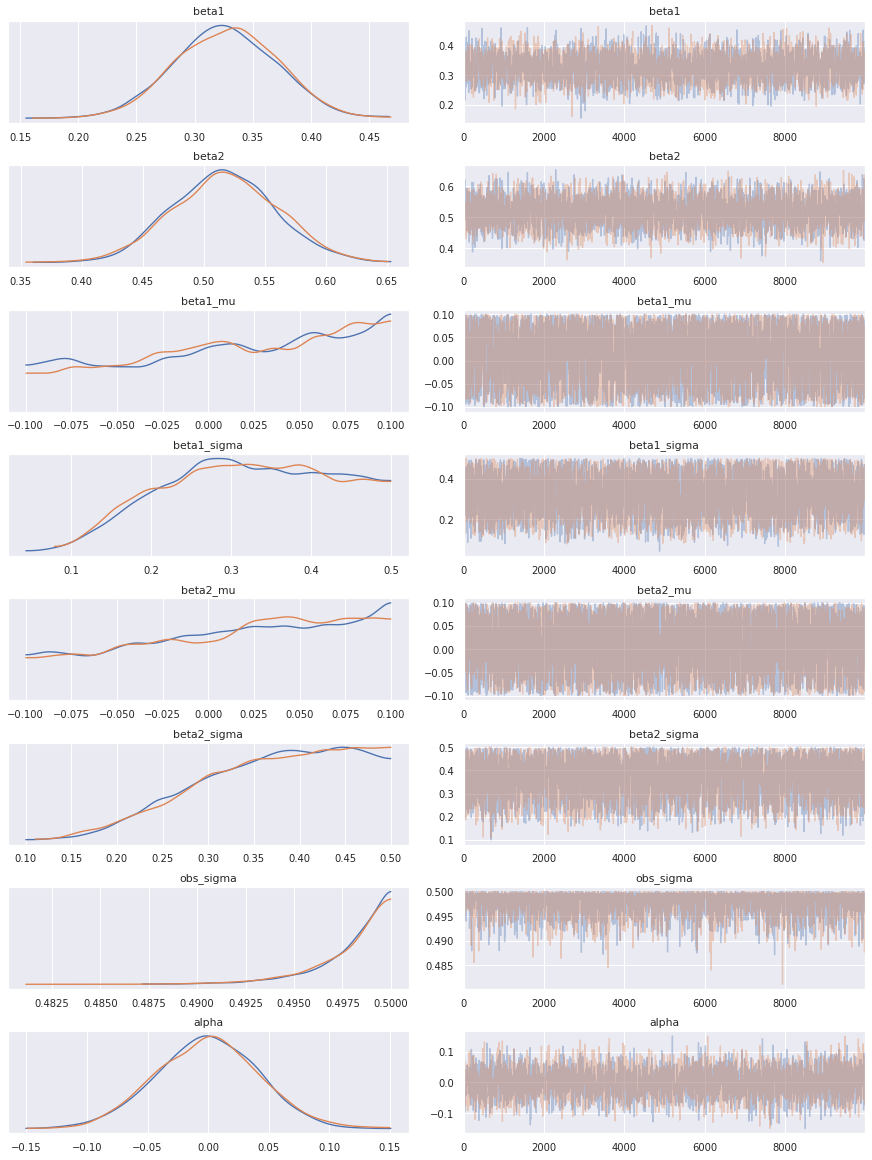

In [195]:


result = regression(xy['x1_std'],xy['x2_std'],xy['y_std'])
print ()
print ('result stats')
print (result.describe())
print()
print ('result covariance matrix')
print (result.cov())
print()
print ('result correlation coeff')
print (result.corr())

In [196]:
def plot(result,x1,x2,y,title,n,df,create_figure=True,residuals = False,color='crimson'):
    
    min_x = (np.minimum(x1,x2)).min()
    max_x = (np.maximum(x1,x2)).max()
    min_y = min(y)
    max_y = max(y)
    
    x1_mu = df[x1_param.replace('_std','')].mean()
    x1_sigma = df[x1_param.replace('_std','')].std()
    x2_mu = df[x2_param.replace('_std','')].mean()
    x2_sigma = df[x2_param.replace('_std','')].std()
    y_mu = df[y_param.replace('_std','')].mean()
    y_sigma = df[y_param.replace('_std','')].std()

    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])

    if create_figure:
        plt.figure(figsize=(18,12))
        #plt.ylim([-outlier,outlier])

    
    plt.title ('{} {}  '.format(
        n, title))

    if not residuals:
        label1 = x1_param + \
                    r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                    x1_param_beta,alpha_param,x1_param_89[0],x1_param_89[1])
        
        if multiple_regression:
            label2 = x2_param + \
                r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                x2_param_beta,alpha_param,x2_param_89[0],x2_param_89[1])              
    else:
        
        label1 = ' '
        
    plt.scatter(x1,y, color=color, label=label1)
    
    if multiple_regression:
        plt.scatter(x2,y,color='g',label=label2)

    X = np.linspace(min_x,max_x,1000)
    
    rows = np.random.choice(result.index,replace=True,size=len(X))

    beta1_samples = result.beta1_post[rows]

    if multiple_regression:
        beta2_samples = result.beta2_post[rows]
    
    alpha_samples = result.alpha_post[rows]

    if multiple_regression:
        lines = [X[i] * beta1_samples + X[i] * beta2_samples + alpha_samples for i in range(len (X))]
        
        
        samples2 = np.array([pm.Normal.dist(X[i] * result.beta1_post[rows] + X[i] * result.beta2_post[rows] + result.alpha_post[rows],
                                      result.obs_sigma_post[rows]).random(size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + X * beta2_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')
        
    else:
        lines = [X[i] * beta1_samples  + alpha_samples for i in range(len (X))]
        rows = np.random.choice(result.index,replace=True,size=len(X))
        
        samples2 = np.array([pm.Normal.dist(X[i] * result.beta1_post[rows] + result.alpha_post[rows],
                                      result.obs_sigma_post[rows]).random(size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')


    plt.plot(X,lines,alpha=0.01,color='r')

    if multiple_regression:
        plt.xlabel(x1_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ] '.format(
            x1_mu,true_x1_mean,x1_sigma,true_x1_std) + \
                   x2_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
            x2_mu,true_x2_mean,x2_sigma,true_x2_std))
        
        if not residuals:
            plt.ylabel(y_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
                y_mu,true_y_mean,y_sigma,true_y_std))

    
    else:
        if not residuals:
            plt.xlabel(x1_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} '.format(x1_mu,x1_sigma) )
            plt.ylabel(y_param + r' $\mu$: {:.2f} $\sigma$: {:.2f}'.format(y_mu,y_sigma))
        else:
            plt.xlabel('predictor')
            plt.ylabel('other predictor residual')
        
    plt.legend(loc='upper left')
    
    if not multiple_regression:
        
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            
    else:
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
                plt.text(x2.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            

    filename = lambda x : x.replace(' ','_').replace('}','_').replace('{','_').replace('-','_')

    plt.savefig('linear_regression_' + filename(title) + '.jpg',format='jpg')

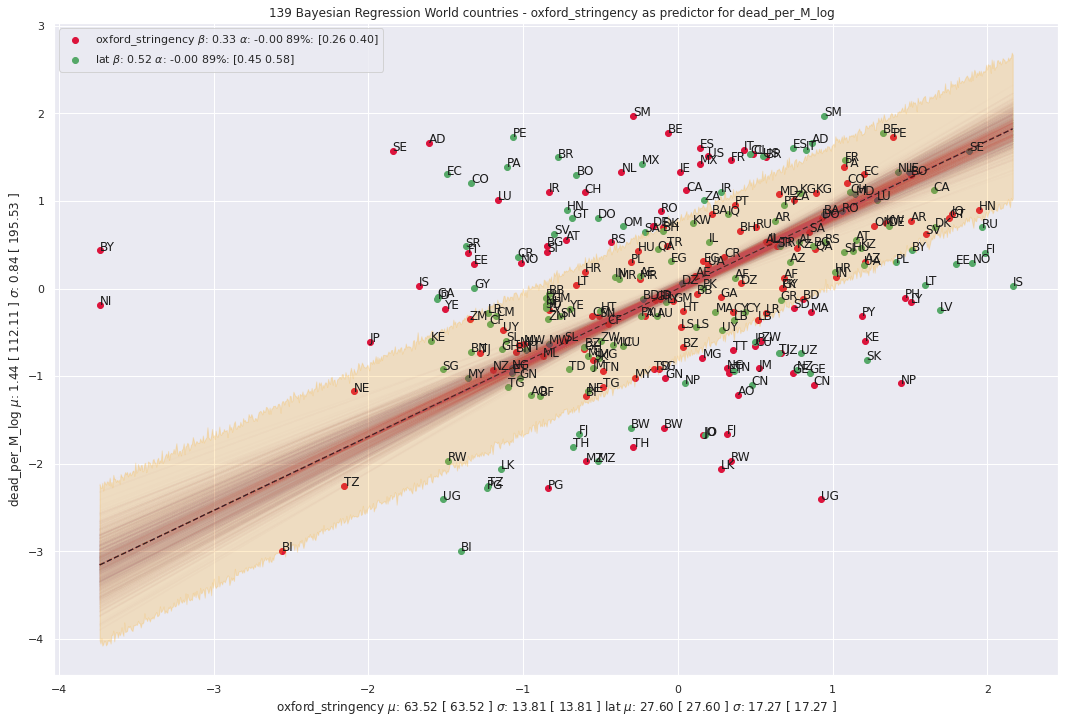

In [197]:
plot(result,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'Bayesian Regression {} - {} as predictor for {}'.format(title, x1_param,y_param),len(xy),xy)



In [198]:
print (xy.head(50))

                      oxford_stringency        lat  dead_per_M_log    x1_std  \
US                            66.205660  37.090240        2.706629  0.194587   
China                         75.652390  35.861660        0.514032  0.878746   
Japan                         36.022390  36.204824        0.931414 -1.991372   
Germany                       61.284717  51.165691        2.042041 -0.161802   
India                         77.632264  20.593684        1.550635  1.022134   
France                        68.237610  46.227638        2.668279  0.341746   
Brazil                        71.354528  14.235004        2.695731  0.567482   
Italy                         69.390314  41.871940        2.765481  0.425228   
Canada                        64.270943  56.130366        2.380685  0.054469   
Russia                        70.462642  61.524010        2.025248  0.502889   
Australia                     60.627358  25.274398        1.172101 -0.209410   
Spain                         65.454177 

In [199]:
def plot_betas(result,title):
    
    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])
        
    plt.figure(figsize=(18,12))
    plt.title('Regression Betas ' + title)
    plt.hist(result.beta1_post,density=True,label=x1_param + \
                r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
        x1_param_beta,x1_param_sigma,x1_param_89[0],x1_param_89[1]),
             color='r',alpha=0.7,histtype='stepfilled')

    if multiple_regression:
        plt.hist(result.beta2_post,density=True,label=x2_param + \
                    r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
            x2_param_beta,x2_param_sigma,x2_param_89[0],x2_param_89[1]),
                 color='g',alpha=0.7,histtype='stepfilled')
    
    plt.legend(loc='upper left')

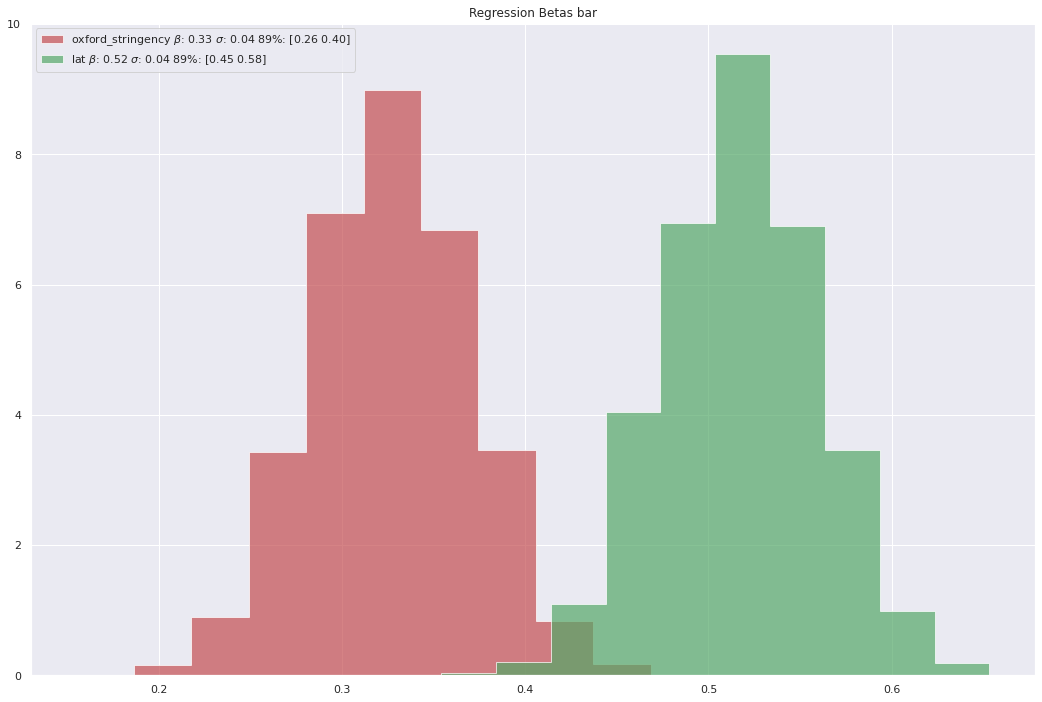

In [200]:
plot_betas(result,'bar')


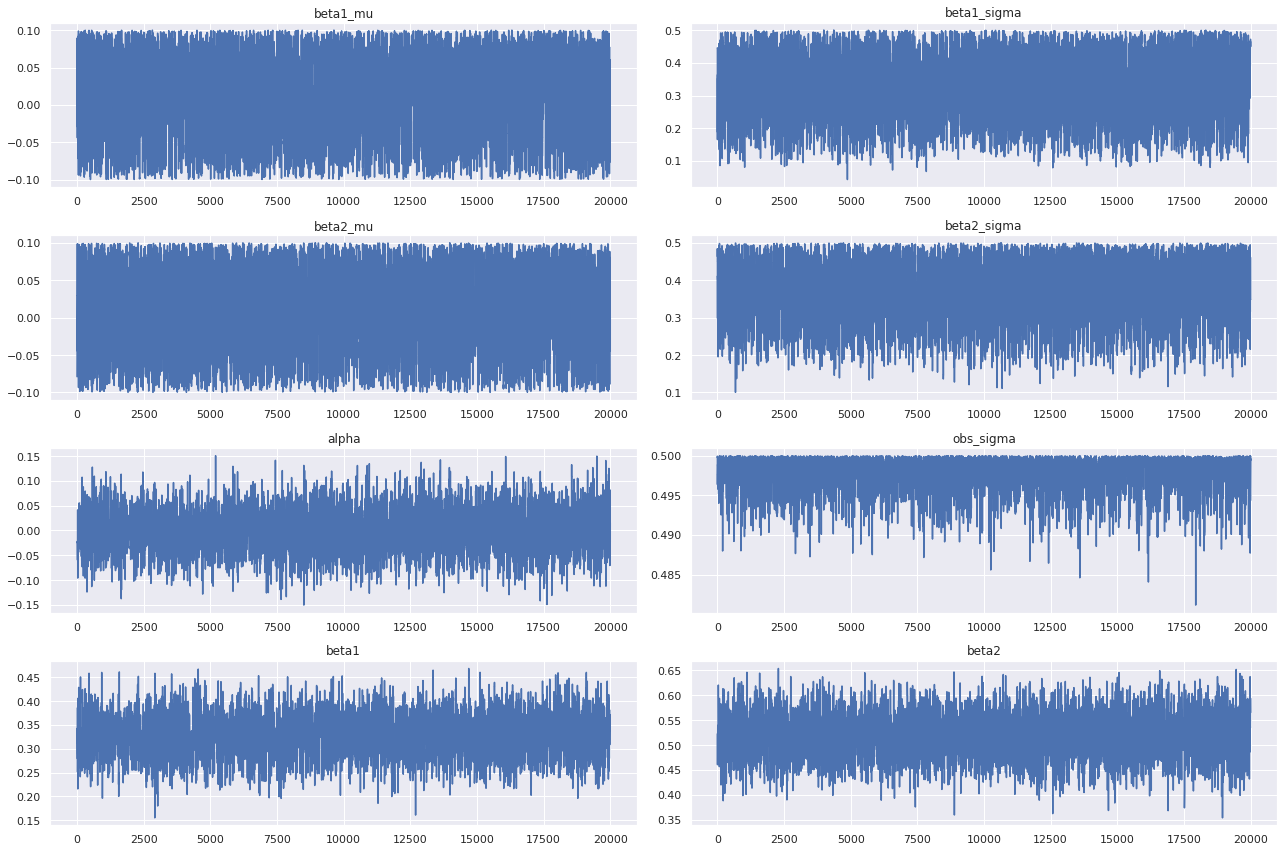

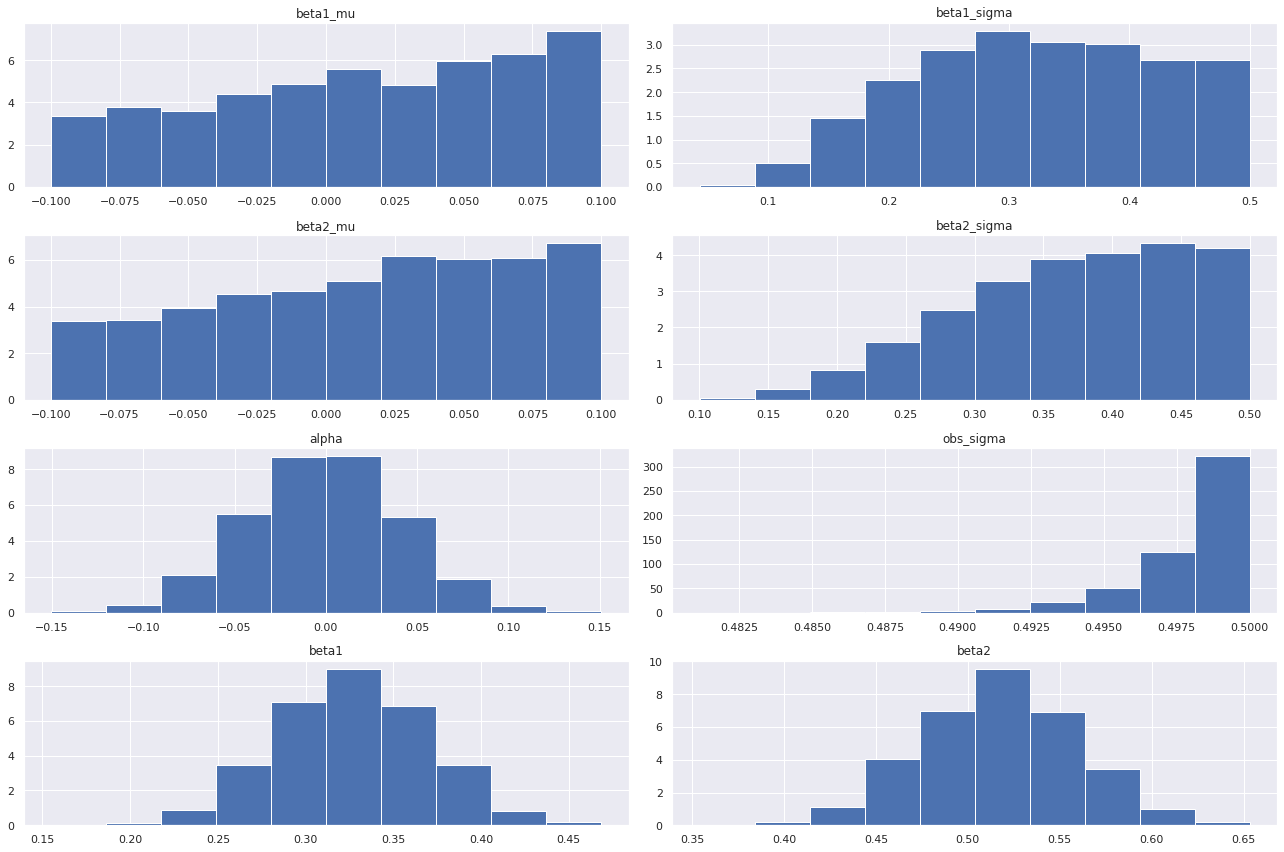

In [201]:
# disable the burn params in mcmc.sample to see the convergence
fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].plot(result.beta1_mu_post)
axes[0,0].set_title('beta1_mu')
axes[0,1].plot(result.beta1_sigma_post)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    axes[1,0].plot(result.beta2_mu_post)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].plot(result.beta2_sigma_post)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].plot(result.alpha_post)
axes[2,0].set_title('alpha')
axes[2,1].plot(result.obs_sigma_post)
axes[2,1].set_title('obs_sigma')
axes[3,0].plot(result.beta1_post)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].plot(result.beta2_post)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].hist(result.beta1_mu_post,density=True)
axes[0,0].set_title('beta1_mu')
axes[0,1].hist(result.beta1_sigma_post,density=True)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    
    axes[1,0].hist(result.beta2_mu_post,density=True)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].hist(result.beta2_sigma_post,density=True)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].hist(result.alpha_post,density=True)
axes[2,0].set_title('alpha')
axes[2,1].hist(result.obs_sigma_post,density=True)
axes[2,1].set_title('obs_sigma')
axes[3,0].hist(result.beta1_post,density=True)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].hist(result.beta2_post,density=True)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 35 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1       -0.19  0.04   -0.27    -0.11        0.0      0.0   3314.61   
beta2       -0.00  0.30   -0.63     0.56        0.0      0.0   3747.30   
beta1_mu    -0.02  0.06   -0.10     0.08        0.0      0.0   3553.40   
beta1_sigma  0.26  0.12    0.07     0.49        0.0      0.0   2813.53   
beta2_mu    -0.00  0.06   -0.09     0.09        0.0      0.0   3192.25   
beta2_sigma  0.26  0.14    0.04     0.50        0.0      0.0   1807.60   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4211.34   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   3358.09   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3314.61   3321.38   3199.53    1.0  
beta2        2855.68   3603.82   4009.34    1.0  
beta1_mu     3044.36   3515.91   4055.27    1.0  
beta1_sigma  2813.53   2719.47   2822.84    1.0  
beta2_mu     3192.25   3211.42   4127.19    1.0  
beta2_sigma  1807.60   1660.84   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.52  0.04    0.44     0.60        0.0      0.0   4124.68   
beta2        0.00  0.29   -0.60     0.59        0.0      0.0   3496.30   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   3950.49   
beta1_sigma  0.37  0.08    0.23     0.50        0.0      0.0   3627.48   
beta2_mu     0.00  0.06   -0.09     0.10        0.0      0.0   2870.95   
beta2_sigma  0.25  0.14    0.01     0.47        0.0      0.0   1755.21   
obs_sigma    0.50  0.00    0.49     0.50        0.0      0.0   4215.64   
alpha       -0.00  0.04   -0.07     0.08        0.0      0.0   3948.54   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        4118.64   4122.82   4235.79    1.0  
beta2        2703.69   3332.49   3681.92    1.0  
beta1_mu     3642.46   3878.76   4309.28    1.0  
beta1_sigma  3520.22   3604.73   3534.27    1.0  
beta2_mu     2701.24   2774.43   3578.94    1.0  
beta2_sigma  1755.21   1640.59   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 36 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1       -0.19  0.04   -0.27    -0.10        0.0      0.0   3454.41   
beta2        0.00  0.31   -0.63     0.62        0.0      0.0   3773.66   
beta1_mu    -0.02  0.06   -0.10     0.08        0.0      0.0   3436.91   
beta1_sigma  0.27  0.12    0.07     0.48        0.0      0.0   2881.11   
beta2_mu     0.00  0.06   -0.09     0.10        0.0      0.0   2703.82   
beta2_sigma  0.26  0.14    0.03     0.50        0.0      0.0   1779.80   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4257.35   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   3927.78   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3454.41   3451.72   3316.37    1.0  
beta2        2721.77   3634.70   3780.08    1.0  
beta1_mu     3411.05   3458.89   4239.29    1.0  
beta1_sigma  2864.61   2703.60   3053.63    1.0  
beta2_mu     2703.82   2737.04   3721.05    1.0  
beta2_sigma  1779.80   1727.63   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 33 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.32  0.04    0.24     0.40        0.0      0.0   3485.31   
beta2       -0.00  0.30   -0.57     0.65        0.0      0.0   4206.67   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   4135.30   
beta1_sigma  0.32  0.10    0.16     0.50        0.0      0.0   3138.44   
beta2_mu    -0.00  0.06   -0.10     0.09        0.0      0.0   2781.03   
beta2_sigma  0.26  0.14    0.03     0.50        0.0      0.0   1822.35   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4499.45   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   3896.35   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3449.86   3487.05   3450.95    1.0  
beta2        2832.06   4081.83   3989.82    1.0  
beta1_mu     3497.72   4085.69   3957.79    1.0  
beta1_sigma  3051.67   3082.69   3409.97    1.0  
beta2_mu     2781.03   2924.70   4140.08    1.0  
beta2_sigma  1822.35   1791.14   

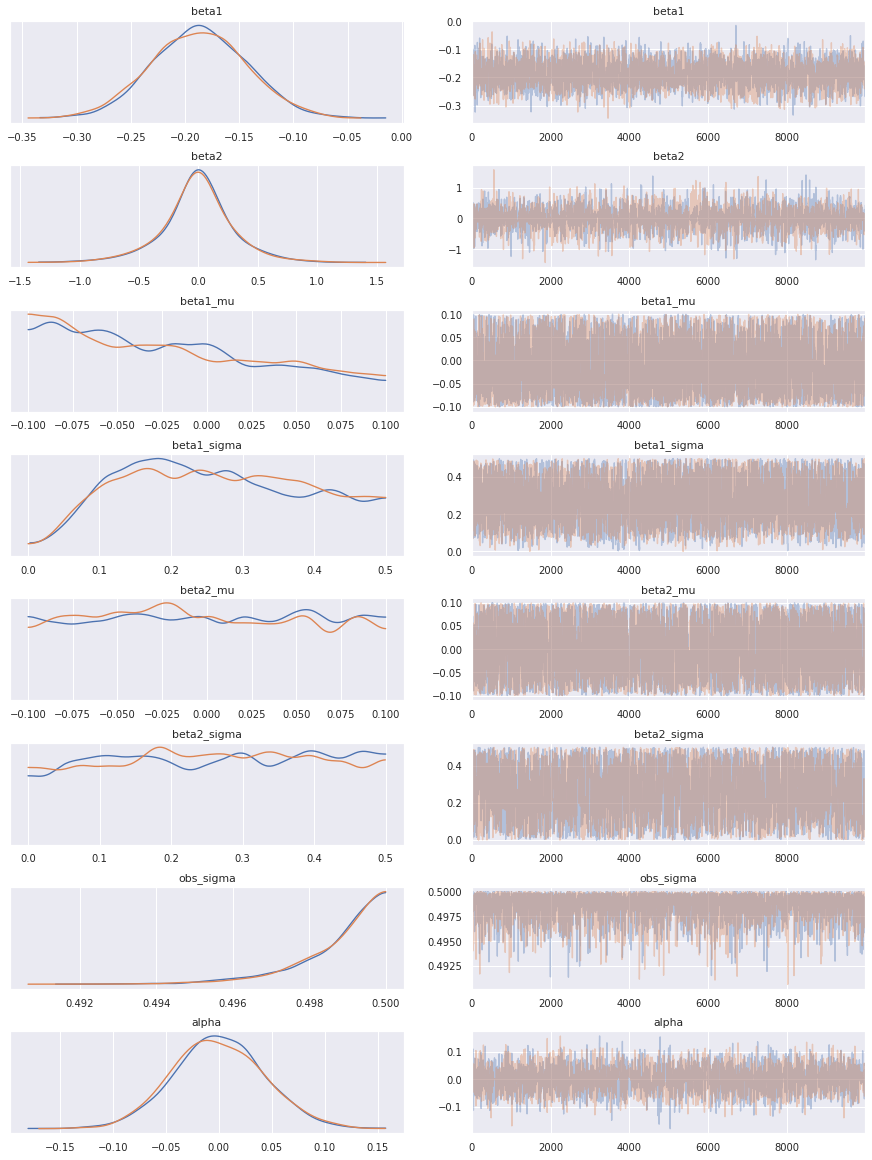

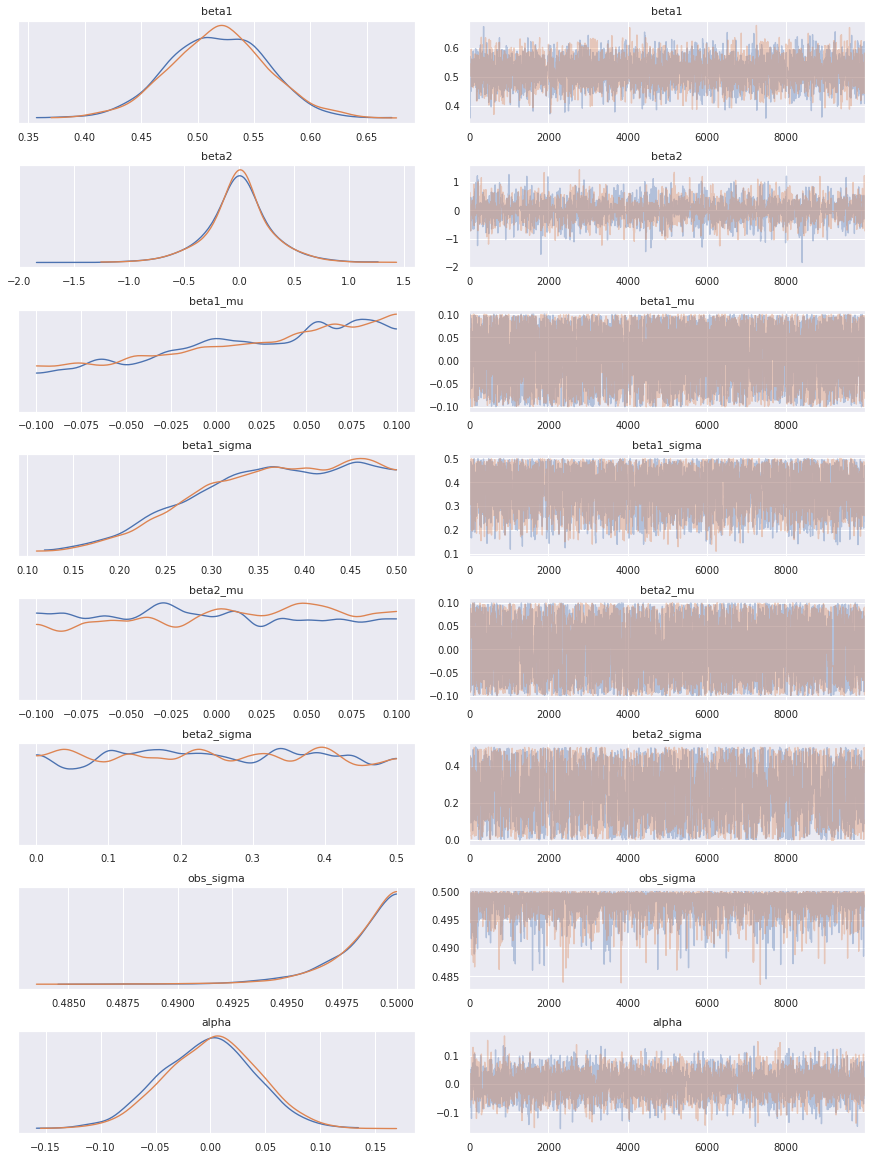

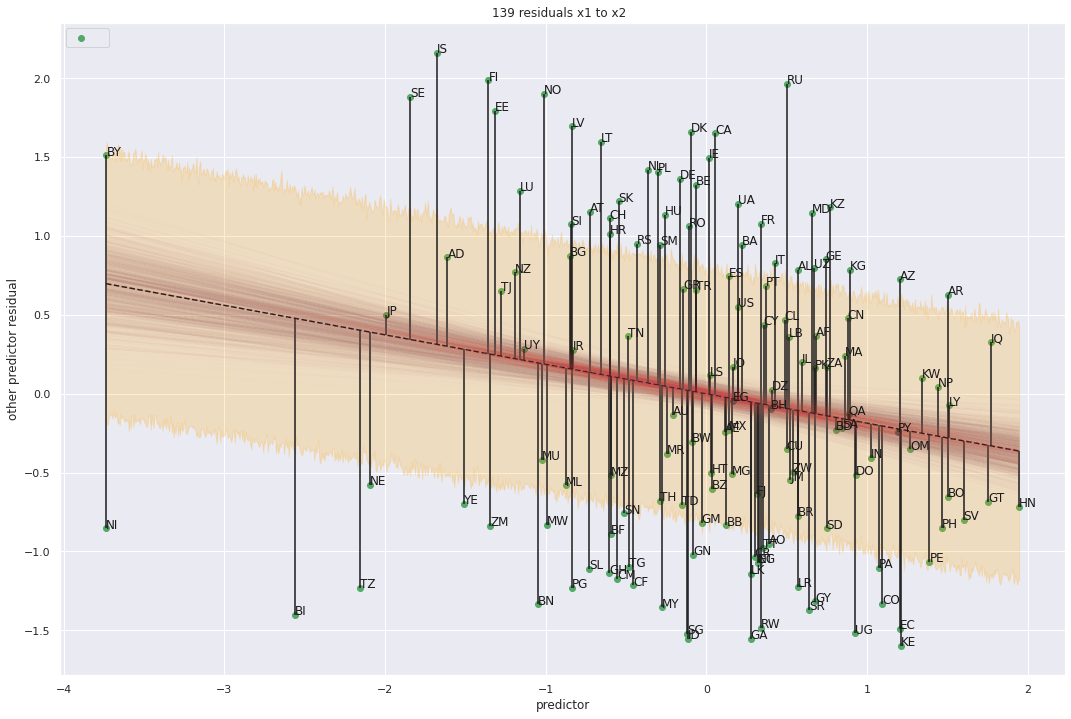

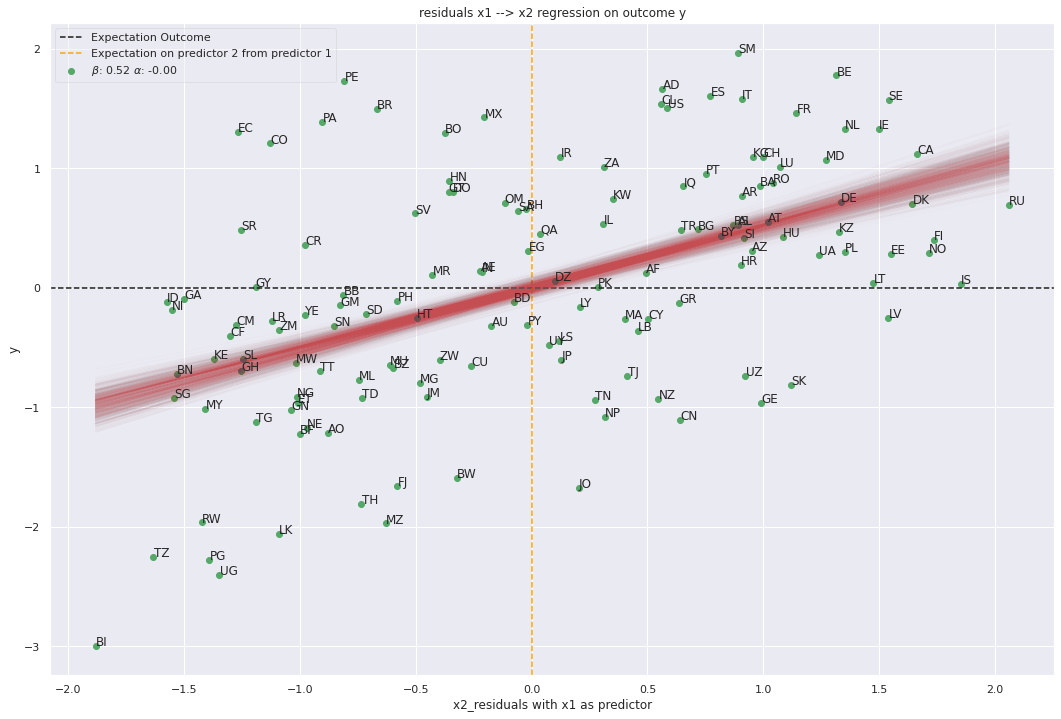

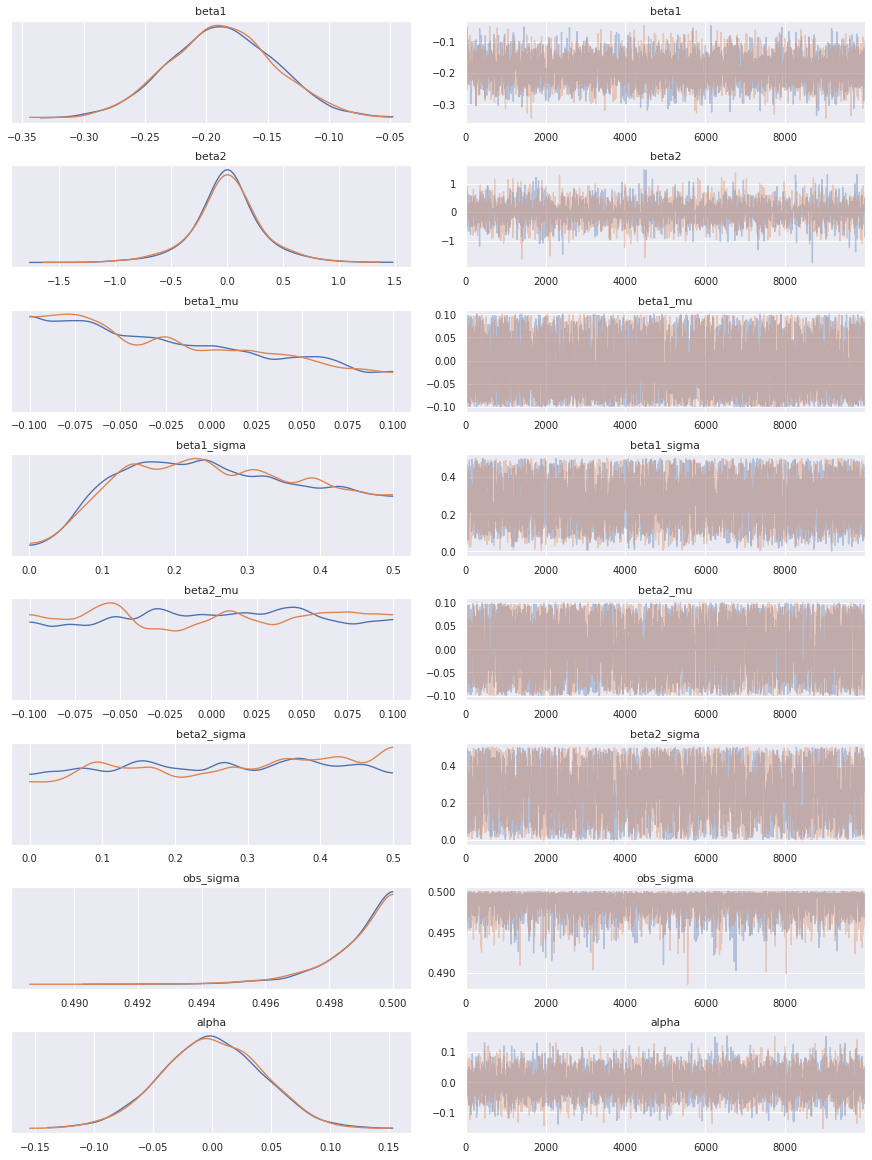

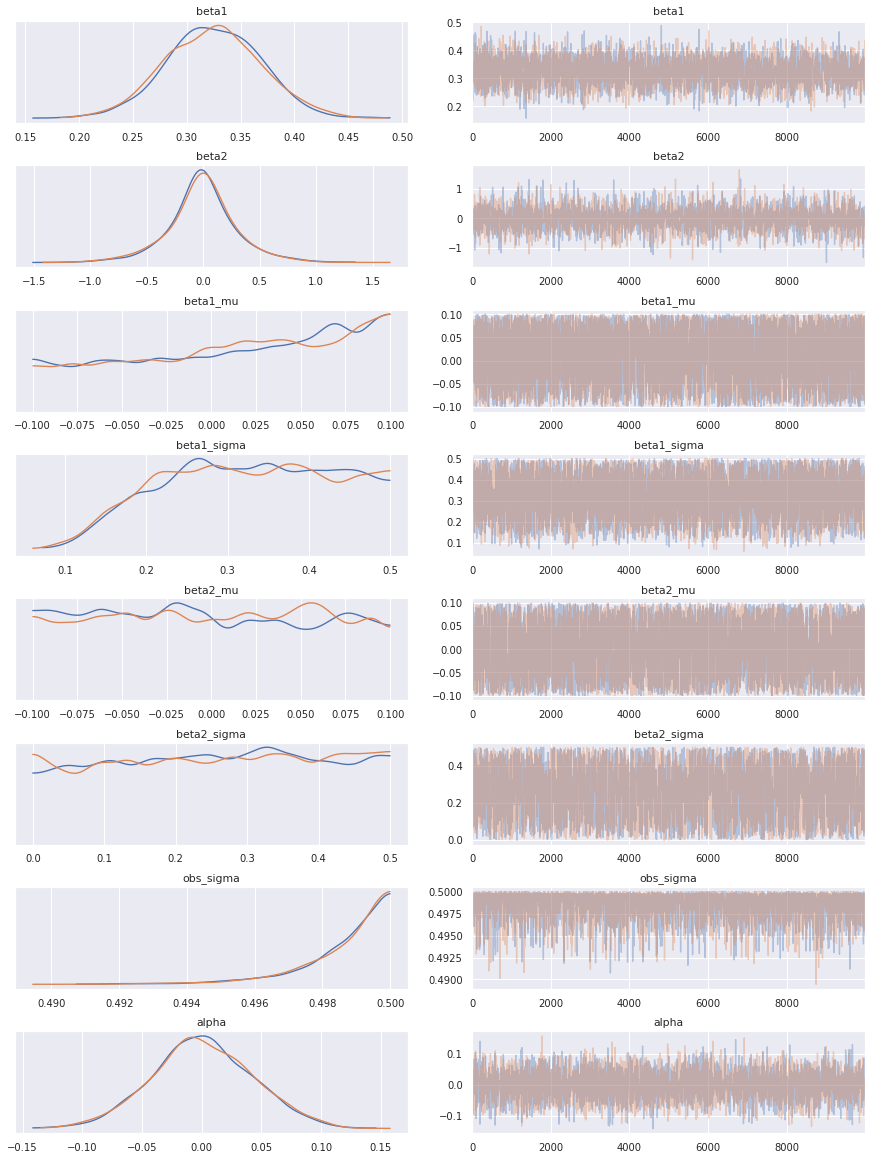

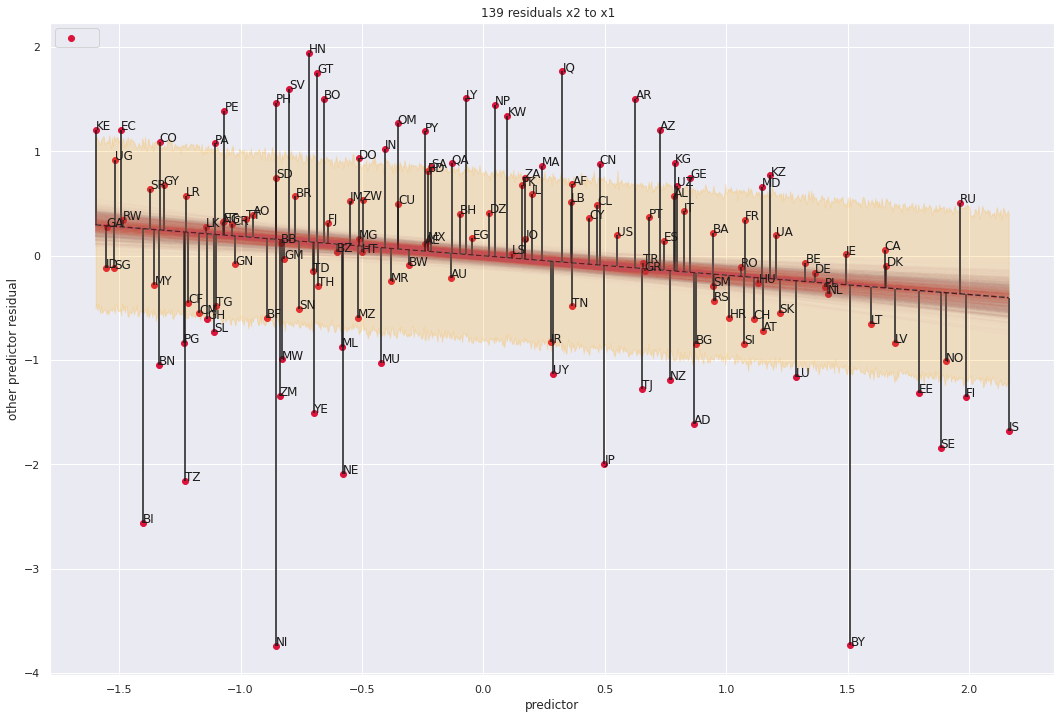

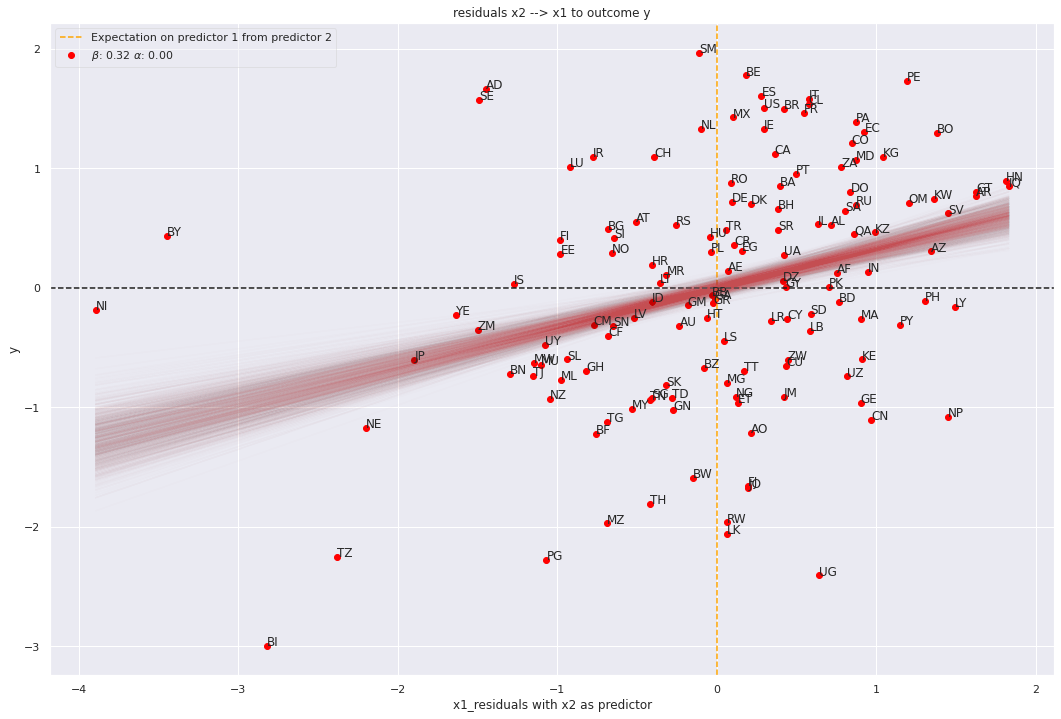

In [202]:
multiple_regression = False


#########
result_x1_x2 = regression(xy['x1_std'],xy['x1_std'],xy['x2_std'])

mean_ys = xy['x1_std'] * result_x1_x2.beta1_post.mean() + result_x1_x2.alpha_post.mean()

low_error = np.zeros_like(xy['x1_std'])
high_error = np.zeros_like(xy['x1_std'])

for i in range(len(low_error)):
    
    if xy['x2_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x1_x2 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x1_x2.index = xy.index

temp = pd.DataFrame({'predictor': xy['x1_std'],
                    'residual' : residuals_x1_x2[0]})

print()
print (temp.head(50))
print()



result_residuals_x1_x2 = regression(residuals_x1_x2[0],residuals_x1_x2[0], xy['y_std'])

plot(result_x1_x2,xy['x1_std'],xy['x1_std'],xy['x2_std'],
     'residuals x1 to x2',len(xy),xy,create_figure=True,residuals=True,color='g')


plt.errorbar(x=xy['x1_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x1_to_x2.jpg',format='jpg')
           

####
plt.figure(figsize=(18,12))
plt.title('residuals x1 --> x2 regression on outcome y')

plt.scatter(residuals_x1_x2,xy['y_std'],color='g',
            label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x1_x2.beta1_post.mean(),
                                                            result_residuals_x1_x2.alpha_post.mean()))

plt.axhline(0,color='k',ls='dashed',label='Expectation Outcome')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 2 from predictor 1')

if US_states or World_countries:
    for s in residuals_x1_x2.index:
        plt.text(residuals_x1_x2.loc[s,0] + 0.001,xy.loc[s,'y_std'] + 0.001,us_abb.loc[s,'abb'])
    
nr_lines = 1000

X = np.linspace(residuals_x1_x2[0].min(),residuals_x1_x2[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x1_x2.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x1_x2.beta1_post[rows] + result_residuals_x1_x2.alpha_post[rows] for i in range(len(X))]


plt.plot(X,lines,alpha=0.01,color='r')  

plt.xlabel('x2_residuals with x1 as predictor')
plt.ylabel('y')

plt.legend(loc='upper left',framealpha=0.4)
plt.savefig('residuals_regression_outcome_plot_x1_x2.jpg',format='jpg')

#########
result_x2_x1 = regression (xy['x2_std'],xy['x2_std'],xy['x1_std'])

mean_ys = xy['x2_std'] * result_x2_x1.beta1_post.mean() + result_x2_x1.alpha_post.mean()

low_error = np.zeros_like(xy['x2_std'])
high_error = np.zeros_like(xy['x2_std'])

for i in range(len(low_error)):
    
    if xy['x1_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x2_x1 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x2_x1.index = xy.index

temp2 = pd.DataFrame({'predictor': xy['x2_std'],
                    'residual' : residuals_x2_x1[0]})

print()
print (temp2.head(50))
print()


###########################################################################


result_residuals_x2_x1 = regression(residuals_x2_x1[0],residuals_x2_x1[0], xy['y_std'])

plot(result_x2_x1,xy['x2_std'],xy['x2_std'],xy['x1_std'],
     'residuals x2 to x1',len(xy),xy,create_figure=True,residuals=True)


plt.errorbar(x=xy['x2_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x2_to_x1.jpg',format='jpg')

            
####
plt.figure(figsize=(18,12))
plt.title('residuals x2 --> x1 to outcome y')

plt.scatter(residuals_x2_x1,xy['y_std'],color='red',
           label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x2_x1.beta1_post.mean(),
                                                            result_residuals_x2_x1.alpha_post.mean()))
plt.axhline(0,color='k',ls='dashed')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 1 from predictor 2')

if US_states or World_countries:
    for s in residuals_x2_x1.index:
        plt.text(residuals_x2_x1.loc[s,0] ,xy.loc[s,'y_std'] ,us_abb.loc[s,'abb'])
    
X = np.linspace(residuals_x2_x1[0].min(),residuals_x2_x1[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x2_x1.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x2_x1.beta1_post[rows] + result_residuals_x2_x1.alpha_post[rows] for i in range(len(X))]

plt.plot(X,lines,alpha=0.01,color='r')  
    
plt.xlabel('x1_residuals with x2 as predictor')
plt.ylabel('y')
plt.legend(loc='upper left',framealpha=0.4)

plt.savefig('residuals_regression_outcome_plot_x2_x1.jpg',format='jpg')

                  0
Russia     2.058215
Iceland    1.850951
Finland    1.734563
Norway     1.714730
Canada     1.662193
...             ...
Singapore -1.542768
Nicaragua -1.550594
Indonesia -1.574633
Tanzania  -1.631777
Burundi   -1.880547

[139 rows x 1 columns]


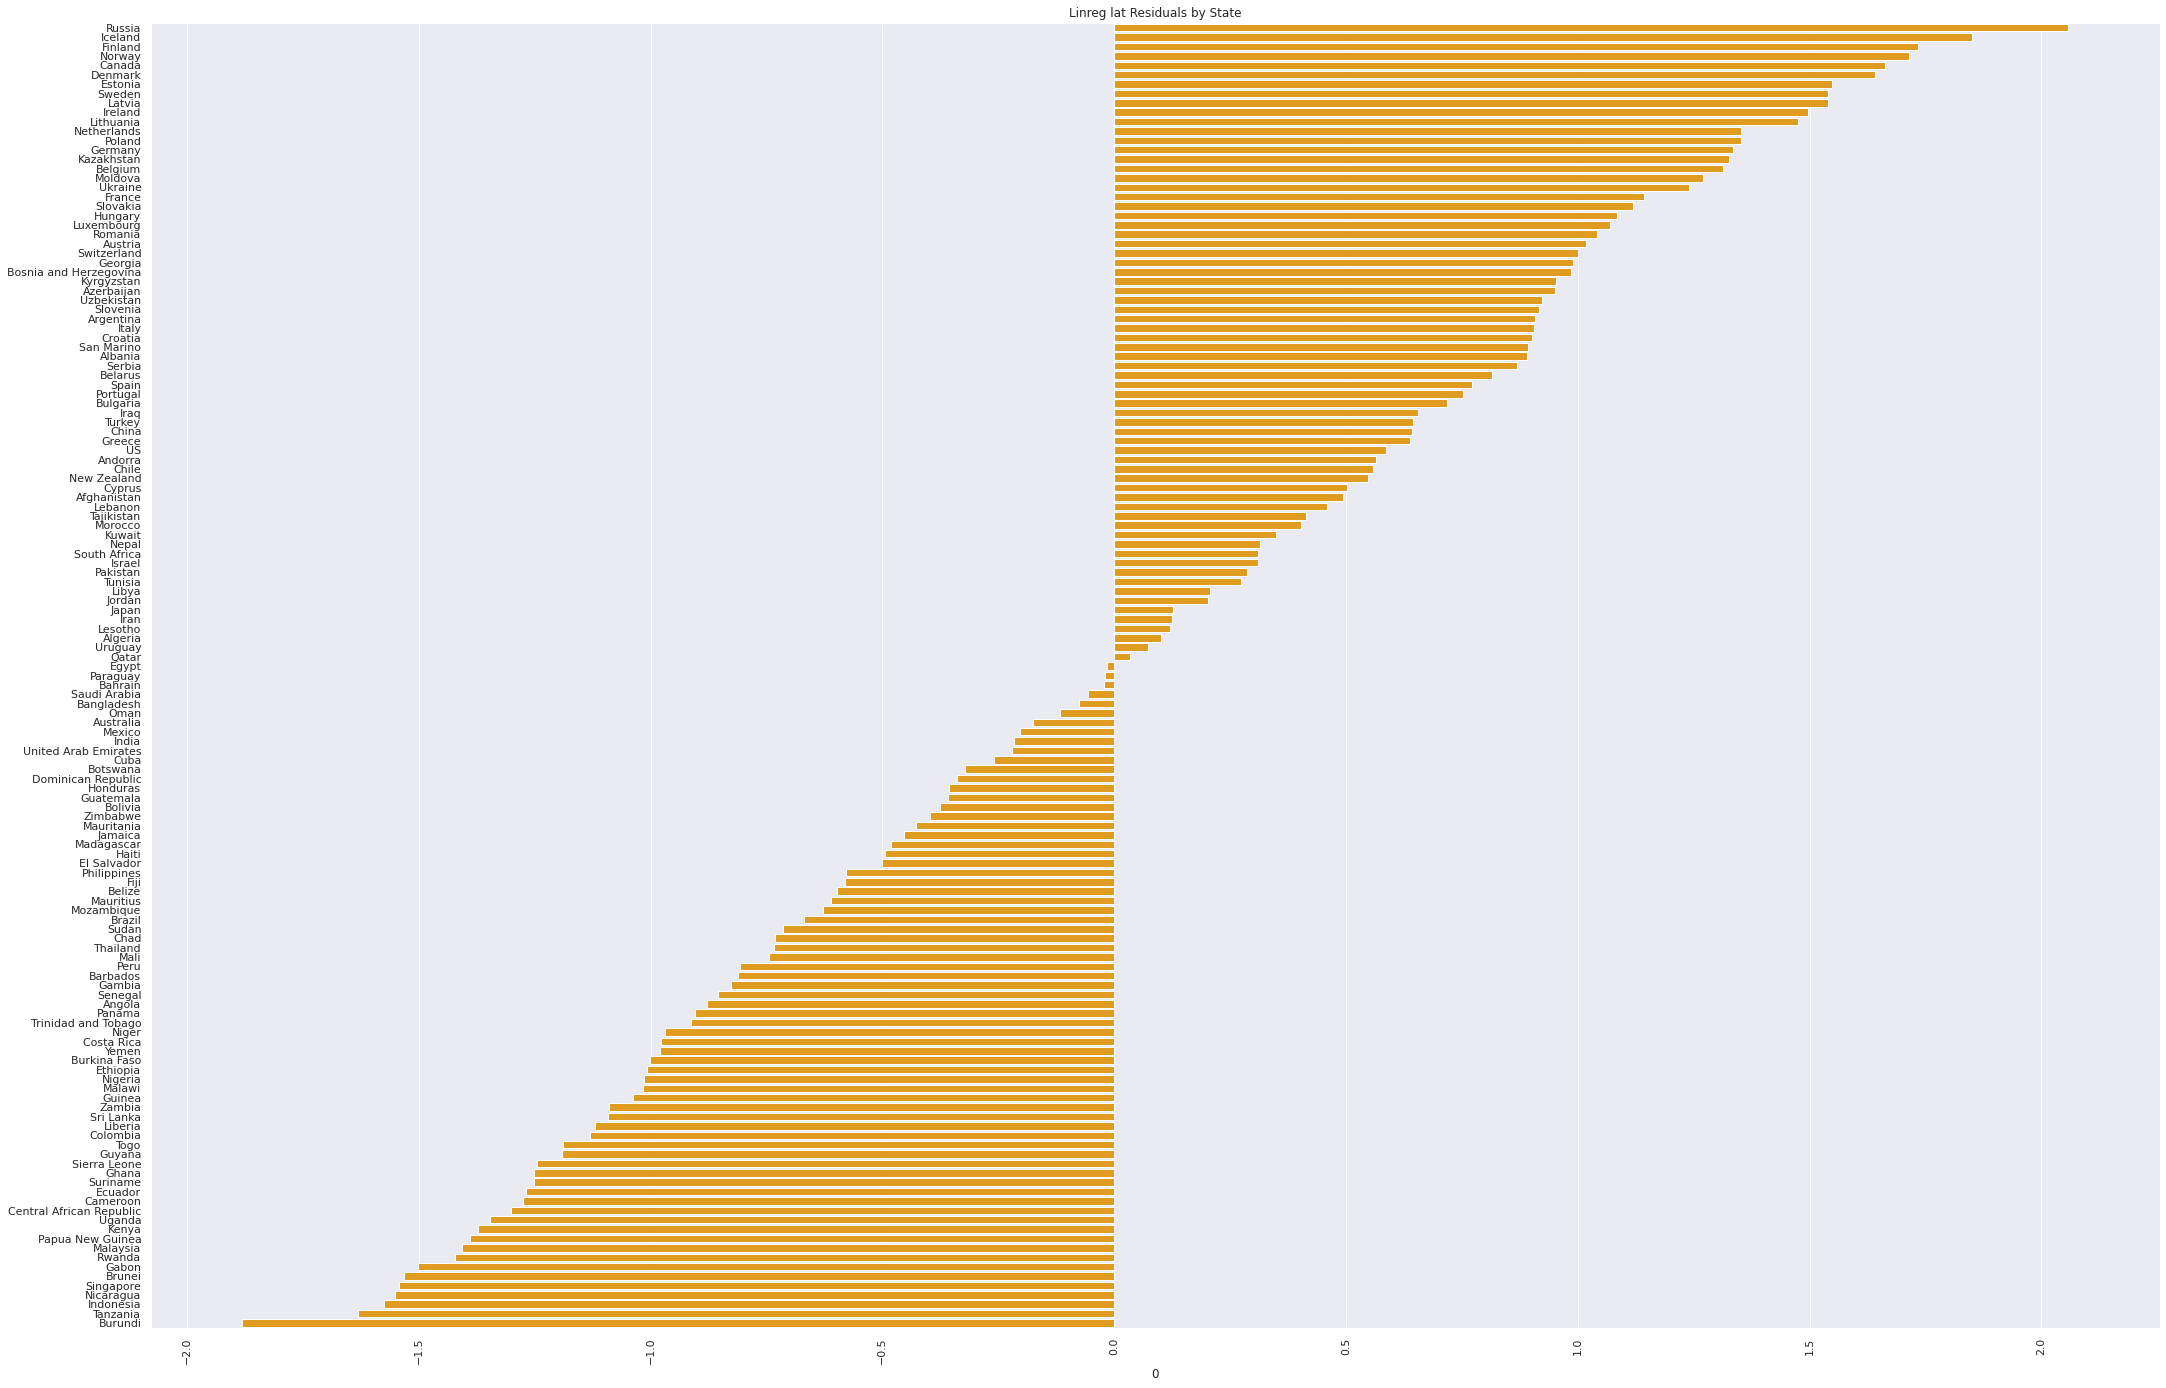

In [203]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x2_param))
    residuals_x1_x2.sort_values(0,inplace=True,ascending=False)
    b = sns.barplot(data=residuals_x1_x2,y=residuals_x1_x2.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x2_param))
    print (residuals_x1_x2)

                  0
Russia     2.058215
Iceland    1.850951
Finland    1.734563
Norway     1.714730
Canada     1.662193
...             ...
Singapore -1.542768
Nicaragua -1.550594
Indonesia -1.574633
Tanzania  -1.631777
Burundi   -1.880547

[139 rows x 1 columns]


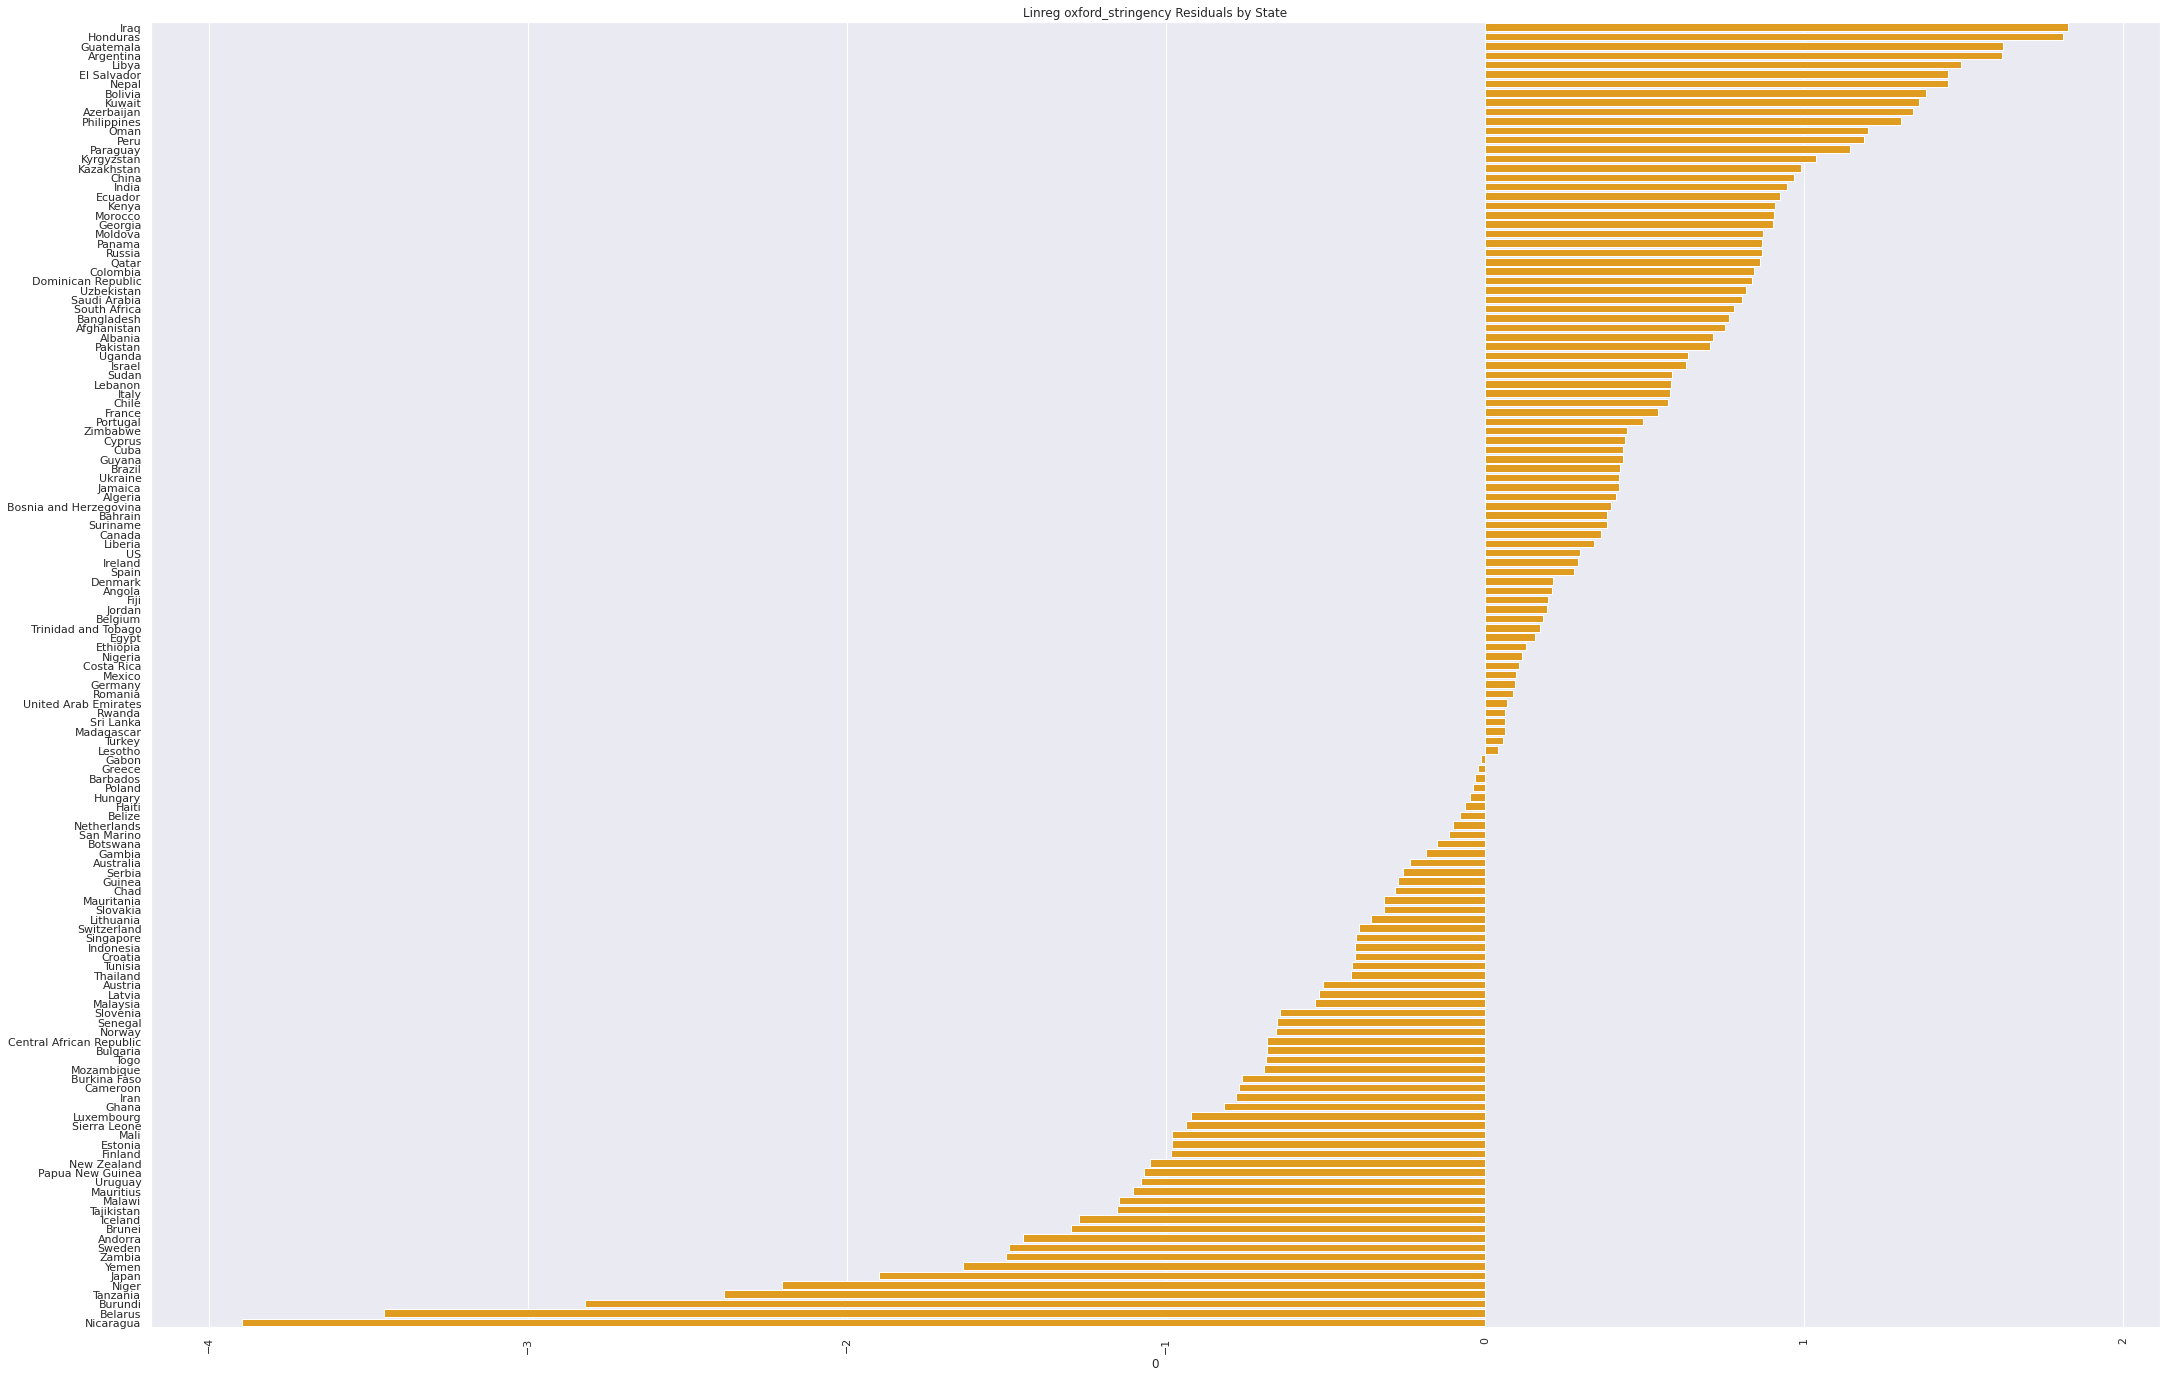

In [204]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x1_param))
    residuals_x2_x1.sort_values(0,inplace=True,ascending=False)
    sns.barplot(data=residuals_x2_x1,y=residuals_x2_x1.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x1_param))
    print (residuals_x1_x2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.00  0.29   -0.59     0.59        0.0      0.0   3990.81   
beta2        0.45  0.04    0.37     0.53        0.0      0.0   3949.46   
beta1_mu    -0.00  0.06   -0.09     0.09        0.0      0.0   2818.80   
beta1_sigma  0.25  0.15    0.03     0.50        0.0      0.0   1755.85   
beta2_mu     0.01  0.06   -0.08     0.10        0.0      0.0   4083.95   
beta2_sigma  0.36  0.09    0.21     0.50        0.0      0.0   3835.84   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4694.44   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   4066.64   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        2709.08   3802.43   3923.84    1.0  
beta2        3947.27   3966.00   4347.50    1.0  
beta1_mu     2818.80   2777.77   3515.32    1.0  
beta1_sigma  1755.85   1716.12   2636.76    1.0  
beta2_mu     3505.75   4016.53   4086.81    1.0  
beta2_sigma  3695.80   3625.00   

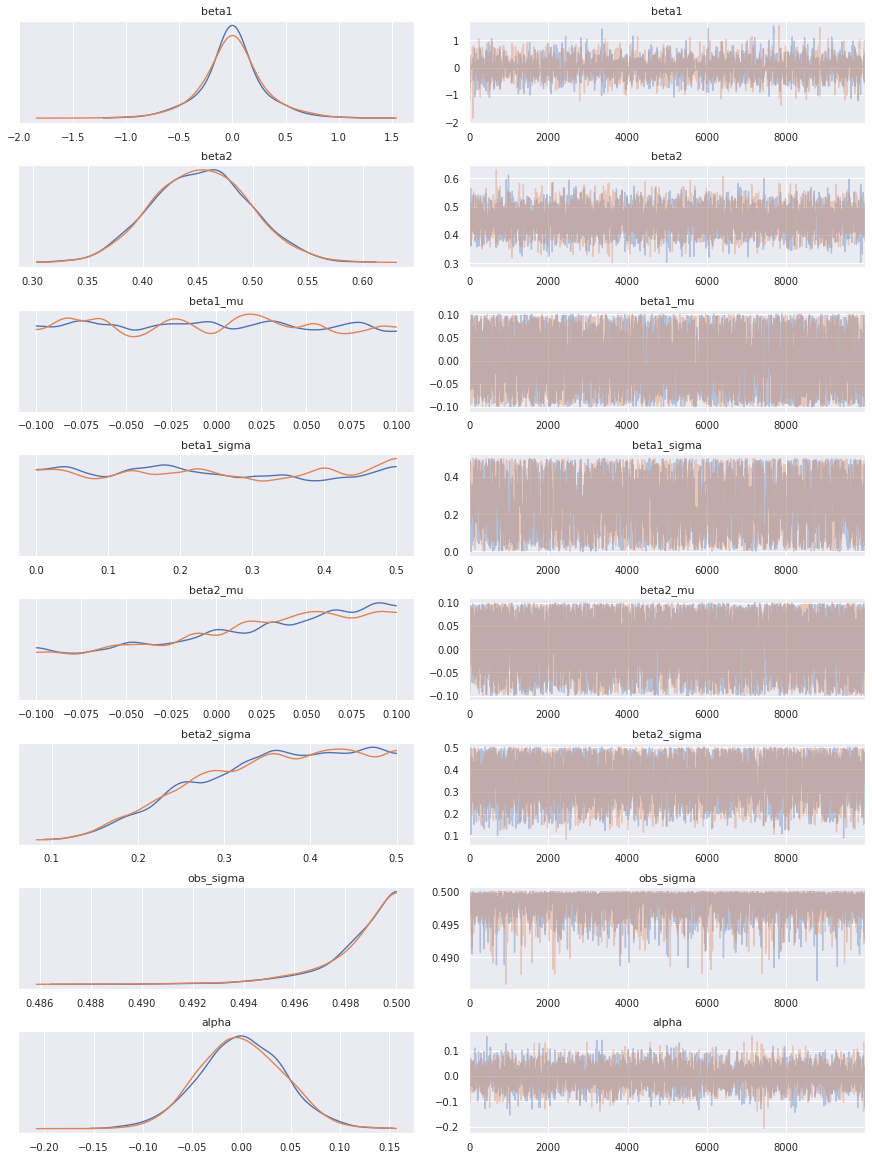

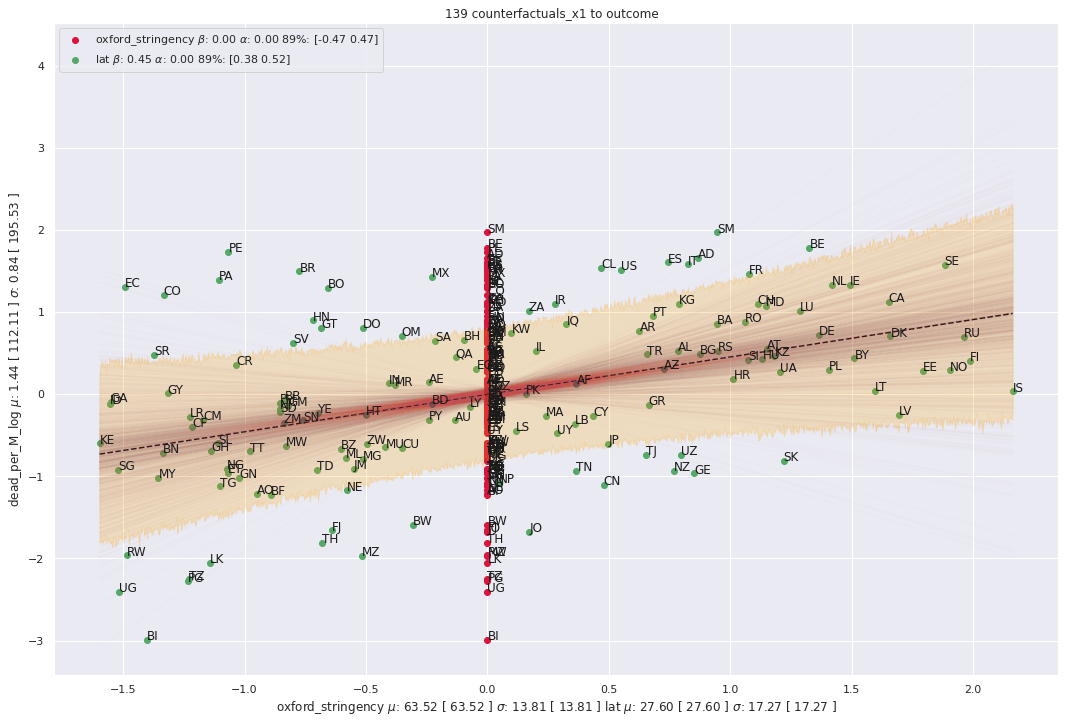

In [205]:
### counterfactual plots

### x1 to mean values
xy['x1_std'] = xy['x1_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x1 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x1,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x1 to outcome',len(xy),xy,create_figure=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.23  0.04    0.14     0.31       0.00      0.0   3313.44   
beta2        0.00  0.30   -0.60     0.61       0.01      0.0   3383.96   
beta1_mu     0.02  0.06   -0.08     0.10       0.00      0.0   3741.81   
beta1_sigma  0.28  0.12    0.11     0.50       0.00      0.0   3225.44   
beta2_mu    -0.00  0.06   -0.09     0.09       0.00      0.0   2663.71   
beta2_sigma  0.25  0.15    0.01     0.48       0.00      0.0   1548.92   
obs_sigma    0.50  0.00    0.50     0.50       0.00      0.0   4731.02   
alpha        0.00  0.04   -0.09     0.07       0.00      0.0   4247.51   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3313.44   3323.65   3775.67    1.0  
beta2        2448.49   3415.28   3804.08    1.0  
beta1_mu     3196.73   3783.80   4031.42    1.0  
beta1_sigma  3216.40   3167.16   3565.03    1.0  
beta2_mu     2596.16   2718.96   3714.47    1.0  
beta2_sigma  1548.92   1509.34   

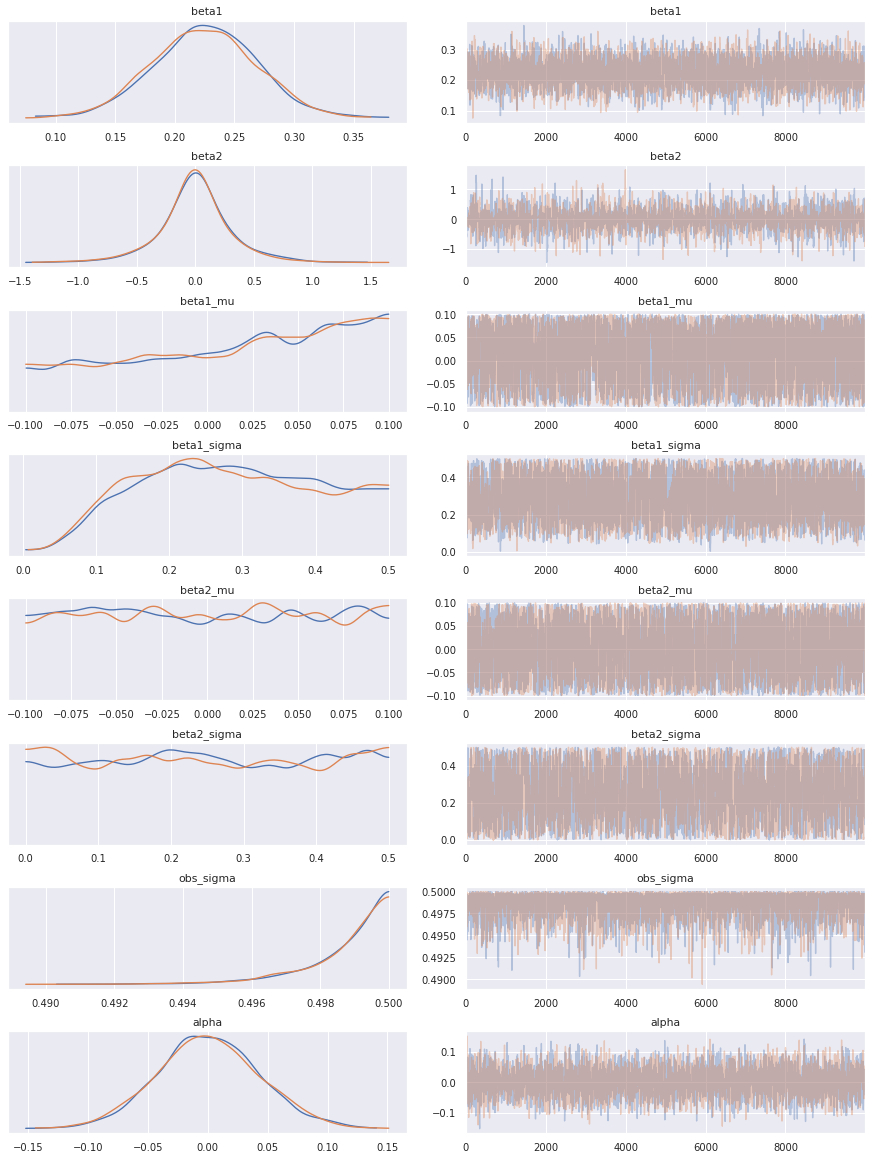

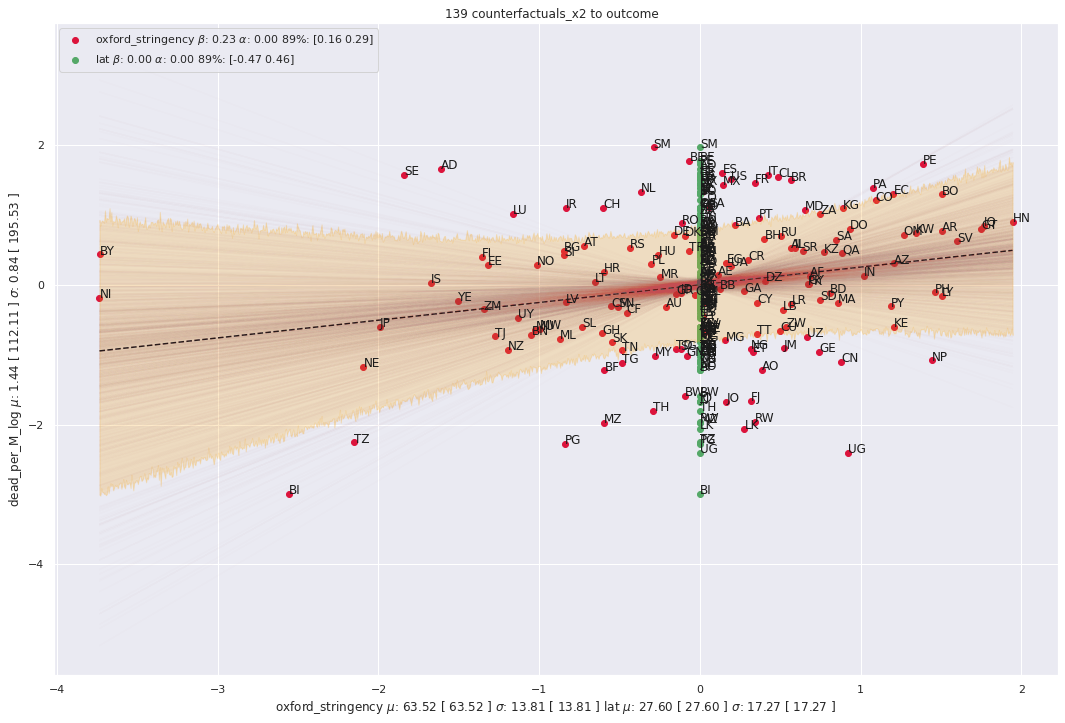

In [206]:
xy = xy_orig.copy()

### x2 to mean values
xy['x2_std'] = xy['x2_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x2 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x2,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x2 to outcome',len(xy),xy,create_figure=True)



       beta1_mu_post  beta1_sigma_post  beta2_mu_post  beta2_sigma_post  \
6616       -0.073505          0.479262       0.055334          0.407362   
5118        0.093916          0.329577      -0.016507          0.417057   
3603        0.044200          0.278441       0.094991          0.416737   
2966       -0.083182          0.376647       0.044825          0.417753   
12301       0.030328          0.297477      -0.074569          0.352503   
...              ...               ...            ...               ...   
4506       -0.062562          0.161471       0.007760          0.251123   
12741       0.095050          0.461852       0.093456          0.442611   
8519        0.038546          0.295652       0.058915          0.388853   
19791       0.018683          0.300275       0.084779          0.173481   
1441        0.088772          0.348012       0.016982          0.371833   

       obs_sigma_post  alpha_post  beta1_post  beta2_post  
6616         0.498222   -0.055368    0.

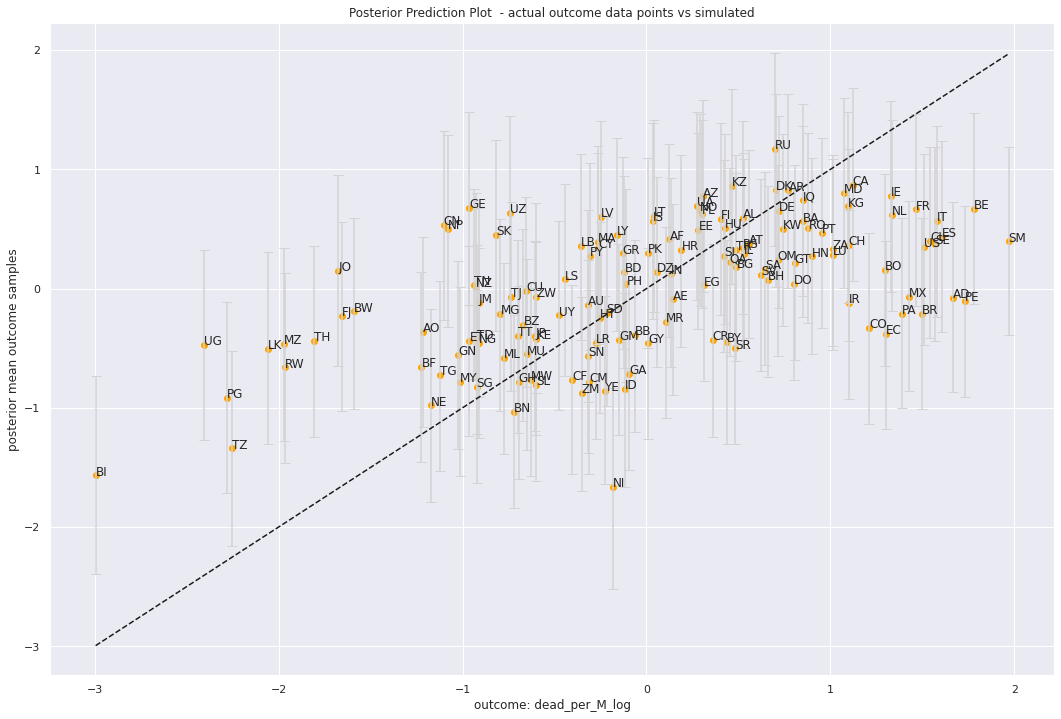

In [207]:
### Posterior prediction plot

xy = xy_orig.copy()

nr_samples = 10000

rows = np.random.choice(result.index,replace=True,size=nr_samples)
samples = result.iloc[rows]
print (samples)

alpha_samples = samples['alpha_post']
beta1_samples = samples['beta1_post']
beta2_samples = samples['beta2_post']
sigma_samples = samples['obs_sigma_post']

X1 = xy['x1_std']
X2 = xy['x2_std']

posterior_samples = np.array([pm.Normal.dist(X1[i] * beta1_samples + X2[i] * beta2_samples + alpha_samples,
                                        sigma_samples ).random(size=nr_samples) for i in range(len(X1))])

print (posterior_samples.shape)

samples_89 = np.percentile(posterior_samples,[5.5,94.4],axis=1)
print (samples_89.mean(axis=1))
print ()


plt.figure(figsize=(18,12))
plt.title('Posterior Prediction Plot  - actual outcome data points vs simulated')

plt.scatter(xy['y_std'],posterior_samples.mean(axis=1),color='orange')

plt.xlabel('outcome: {}'.format(y_param))
plt.ylabel('posterior mean outcome samples')


plt.errorbar(x=xy['y_std'],
             y=posterior_samples.mean(axis=1),ecolor='lightgrey',capsize=5,
             yerr=np.array((np.abs(posterior_samples.mean(axis=1) - samples_89[0]), 
                            np.abs(posterior_samples.mean(axis=1) - samples_89[1]))),fmt='none')

plt.plot(np.linspace(xy['y_std'].min(),
                     xy['y_std'].max(),100),np.linspace(xy['y_std'].min(),xy['y_std'].max(),100),
         color='k',ls='dashed')


for i,s in enumerate(xy.index):
    plt.text(xy['y_std'].loc[s] ,(posterior_samples.mean(axis=1))[i] ,us_abb.loc[s,'abb'])
    

    
plt.savefig('regression_posterior_plot_{}.jpg'.format(y_param),format='jpg')
    